# Table of Contents
 <p><div class="lev1 toc-item"><a href="#plot-the-data" data-toc-modified-id="plot-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>plot the data</a></div><div class="lev2 toc-item"><a href="#Fst" data-toc-modified-id="Fst-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fst</a></div><div class="lev3 toc-item"><a href="#FST-by-MAF" data-toc-modified-id="FST-by-MAF-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>FST by MAF</a></div><div class="lev3 toc-item"><a href="#Models" data-toc-modified-id="Models-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Models</a></div><div class="lev4 toc-item"><a href="#Bottleneck-in-ERY" data-toc-modified-id="Bottleneck-in-ERY-1121"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>Bottleneck in ERY</a></div><div class="lev4 toc-item"><a href="#Bottleneck-in-PAR" data-toc-modified-id="Bottleneck-in-PAR-1122"><span class="toc-item-num">1.1.2.2&nbsp;&nbsp;</span>Bottleneck in PAR</a></div><div class="lev4 toc-item"><a href="#Expansion-in-ERY" data-toc-modified-id="Expansion-in-ERY-1123"><span class="toc-item-num">1.1.2.3&nbsp;&nbsp;</span>Expansion in ERY</a></div><div class="lev4 toc-item"><a href="#Expansion-in-PAR" data-toc-modified-id="Expansion-in-PAR-1124"><span class="toc-item-num">1.1.2.4&nbsp;&nbsp;</span>Expansion in PAR</a></div><div class="lev3 toc-item"><a href="#Get-Fst-by-MAF-for-each-model" data-toc-modified-id="Get-Fst-by-MAF-for-each-model-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Get Fst by MAF for each model</a></div><div class="lev2 toc-item"><a href="#marginal-spectra" data-toc-modified-id="marginal-spectra-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>marginal spectra</a></div><div class="lev2 toc-item"><a href="#preparation" data-toc-modified-id="preparation-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>preparation</a></div><div class="lev1 toc-item"><a href="#simple-divergence-model" data-toc-modified-id="simple-divergence-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>simple divergence model</a></div><div class="lev2 toc-item"><a href="#Interpretation" data-toc-modified-id="Interpretation-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Interpretation</a></div><div class="lev2 toc-item"><a href="#plot-residuals" data-toc-modified-id="plot-residuals-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>plot residuals</a></div><div class="lev1 toc-item"><a href="#divergence-with-migration-model" data-toc-modified-id="divergence-with-migration-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>divergence with migration model</a></div><div class="lev2 toc-item"><a href="#plot" data-toc-modified-id="plot-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>plot</a></div><div class="lev2 toc-item"><a href="#Translation-of-m" data-toc-modified-id="Translation-of-m-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Translation of <em>m</em></a></div><div class="lev2 toc-item"><a href="#LRT" data-toc-modified-id="LRT-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LRT</a></div><div class="lev1 toc-item"><a href="#Recent-secondary-contact-model" data-toc-modified-id="Recent-secondary-contact-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recent secondary contact model</a></div><div class="lev2 toc-item"><a href="#plot-residuals" data-toc-modified-id="plot-residuals-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>plot residuals</a></div><div class="lev2 toc-item"><a href="#Compare-best-fit-IM-with-RSC-model-spectrum" data-toc-modified-id="Compare-best-fit-IM-with-RSC-model-spectrum-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Compare best fit IM with RSC model spectrum</a></div><div class="lev1 toc-item"><a href="#different-migration-rates-for-each-direction" data-toc-modified-id="different-migration-rates-for-each-direction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>different migration rates for each direction</a></div><div class="lev2 toc-item"><a href="#plain-English" data-toc-modified-id="plain-English-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>plain English</a></div><div class="lev2 toc-item"><a href="#LRT" data-toc-modified-id="LRT-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LRT</a></div><div class="lev2 toc-item"><a href="#Is-the-migration-rate-from-ery-into-par-(m1)-statistically-significant?" data-toc-modified-id="Is-the-migration-rate-from-ery-into-par-(m1)-statistically-significant?-53"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Is the migration rate from ery into par (<em>m1</em>) statistically significant?</a></div><div class="lev2 toc-item"><a href="#plot" data-toc-modified-id="plot-54"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>plot</a></div><div class="lev1 toc-item"><a href="#recent-bottleneck" data-toc-modified-id="recent-bottleneck-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>recent bottleneck</a></div><div class="lev2 toc-item"><a href="#Interpretation" data-toc-modified-id="Interpretation-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Interpretation</a></div><div class="lev2 toc-item"><a href="#Residuals" data-toc-modified-id="Residuals-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Residuals</a></div><div class="lev1 toc-item"><a href="#exponential-size-changes-after-split" data-toc-modified-id="exponential-size-changes-after-split-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>exponential size changes after split</a></div><div class="lev2 toc-item"><a href="#Plot" data-toc-modified-id="Plot-71"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plot</a></div><div class="lev1 toc-item"><a href="#Ancient-migration-model" data-toc-modified-id="Ancient-migration-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Ancient migration model</a></div><div class="lev2 toc-item"><a href="#plot" data-toc-modified-id="plot-81"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>plot</a></div><div class="lev2 toc-item"><a href="#plain-English" data-toc-modified-id="plain-English-82"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>plain English</a></div><div class="lev2 toc-item"><a href="#comparison-with-split_asym_mig" data-toc-modified-id="comparison-with-split_asym_mig-83"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>comparison with <code>split_asym_mig</code></a></div><div class="lev1 toc-item"><a href="#ancient-migration,-isolation-and-secondary-contact" data-toc-modified-id="ancient-migration,-isolation-and-secondary-contact-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>ancient migration, isolation and secondary contact</a></div>

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy as np

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules
[stdout:0] error in importing Two Locus modules
[stdout:1] error in importing Two Locus modules
[stdout:2] error in importing Two Locus modules
[stdout:3] error in importing Two Locus modules
[stdout:4] error in importing Two Locus modules
[stdout:5] error in importing Two Locus modules
[stdout:6] error in importing Two Locus modules
[stdout:7] error in importing Two Locus modules
[stdout:8] error in importing Two Locus modules
[stdout:9] error in importing Two Locus modules
[stdout:10] error in importing Two Locus modules
[stdout:11] error in importing Two Locus modules


In [3]:
%ll dadiExercises/

total 33676
lrwxrwxrwx 1 claudius       53 Feb 17  2017 ERY.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/ERY/ERY.FOLDED.sfs
-rw-rw-r-- 1 claudius      499 Mar 24 14:04 ERY.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      499 Mar 24 14:02 ERY.FOLDED.sfs.dadi_format~
lrwxrwxrwx 1 claudius       37 Feb 18  2017 EryPar.unfolded.2dsfs -> ../../ANGSD/FST/EryPar.unfolded.2dsfs
-rw-rw-r-- 1 claudius    13051 Feb 18  2017 EryPar.unfolded.2dsfs.dadi_format
-rw-rw-r-- 1 claudius    13051 Feb 18  2017 EryPar.unfolded.2dsfs.dadi_format~
drwxrwxr-x 5 claudius     4096 Feb 17  2017 examples/
-rw-rw-r-- 1 claudius   155251 Mar 22 12:37 example_YRI_CEU.ipynb
-rw-rw-r-- 1 claudius   619699 Jul 16 15:59 First_Steps_with_dadi.ipynb
-rw-rw-r-- 1 claudius     1012 Mar 16 09:54 new.bib
lrwxrwxrwx 1 claudius       53 Feb 17  2017 PAR.FOLDED.sfs -> /data3/claudius/Big_Data/ANGSD/SFS/PAR/PAR.FOLDED.sfs
-rw-rw-r-- 1 claudius      486 Mar 24 20:08 PAR.FOLDED.sfs.dadi_format
-rw-rw-r-- 1 claudius      450 Mar

In [9]:
%less dadiExercises/EryPar.unfolded.2dsfs.dadi_format

# plot the data

In [3]:
# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [3]:
%page sfs2d_unfolded

In [4]:
sfs2d_unfolded.sample_sizes

array([36, 36])

In [5]:
# add population labels

sfs2d_unfolded.pop_ids = ["ery", "par"]

**For the estimation of the 2D SFS, `realSFS` has only taken sites that had data from at least 9 individuals in *each* population (see [`assembly.sh`](https://github.com/claudiuskerth/PhDthesis/blob/master/Data_analysis/SNP-indel-calling/assembly.sh), lines 1430 onwards).**

In [6]:
# print total number of sites from which the spectrum was estimated
# i. e. also invariant sites

sfs2d_unfolded.data.sum()

1130775.0000030003

In [7]:
# print number of segregating sites in the SFS

sfs2d_unfolded.S()

60573.584426000001

The 2D spectrum contains counts from 60k sites that are variable in *par* or *ery* or both.

In [8]:
# percent variable sites
sfs2d_unfolded.S()/sfs2d_unfolded.data.sum()*100

5.3568202715694353

In [6]:
import pylab

%matplotlib inline

pylab.rcParams['font.size'] = 14.0
pylab.rcParams['figure.figsize'] = [10.0, 8.0]

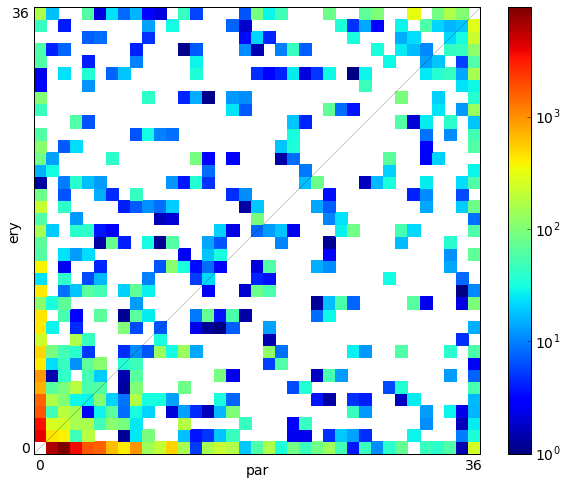

In [7]:
dadi.Plotting.plot_single_2d_sfs(sfs2d_unfolded, vmin=1, cmap='jet')

Cells with counts below 1 are masked and appear white in the upper plot.

In [22]:
%psource dadi.Plotting.plot_single_2d_sfs

[More colormaps](http://www.scipy-lectures.org/intro/matplotlib/index.html#colormaps)

/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


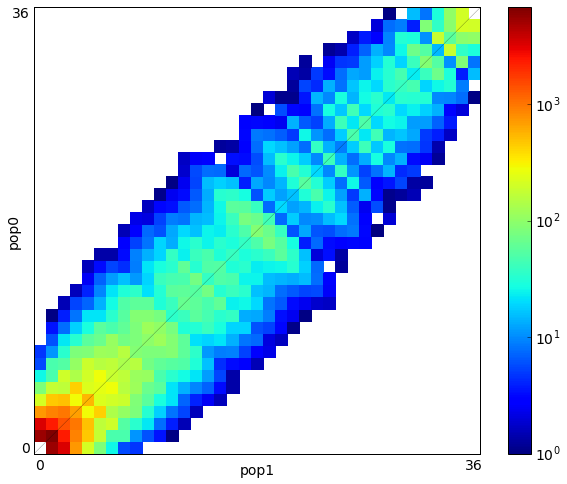

In [13]:
# How would the SFS look like if the samples were taken from a panmictic population?

dadi.Plotting.plot_single_2d_sfs(sfs2d_unfolded.scramble_pop_ids(), vmin=1, cmap='jet')

## Fst

In [59]:
# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [8]:
# get genome-wide Weir & Cockerham's Fst from 2D SFS

sfs2d_unfolded.Fst()

0.26527944085739236

### FST by MAF

I would like to get Fst estimates for subsets of sites with a certain minor allele frequency in ERY or in PAR (see Bhatia2013).

In [43]:
import numpy as np

# initialise an empty 2D array
np.zeros((37, 37))

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [64]:
# initialise an empty 2D array
x = np.zeros(sfs2d_unfolded.sample_sizes+1)
x

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

0.298523883135832

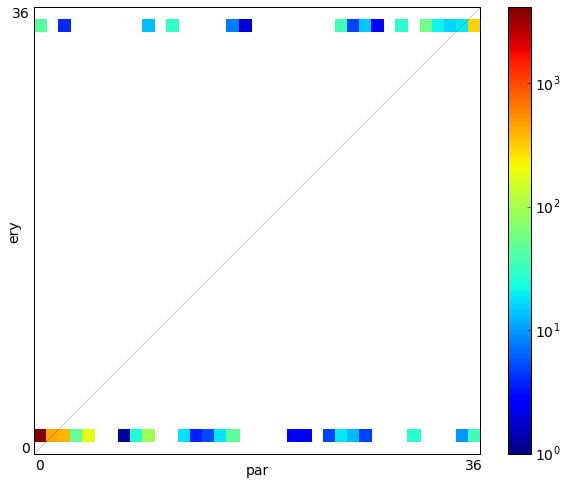

In [9]:
# test Fst calculation for MAF class

# extract sites that correspond to MAF in ERY
x = np.zeros(sfs2d_unfolded.sample_sizes+1)
n = len(x[1])-1
i = 1
x[i] = sfs2d_unfolded.data[i].copy()
x[(n-i)] = sfs2d_unfolded.data[(n-i)].copy()

# create new Spectrum object
x_one = dadi.Spectrum(data=x, mask=sfs2d_unfolded.mask, data_folded=False, pop_ids=['ery', 'par'])

# plot the spectrum of subset sites
dadi.Plotting.plot_single_2d_sfs(x_one, vmin=1, cmap='jet')

# calculate Fst for subset sites
x_one.Fst()

In [10]:
Fst_by_MAF_ery = np.zeros((18))
Fst_by_MAF_ery

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [11]:
# get Fst by MAF in ERY from 1..18
n = len(x[1])-1
for i in range(len(Fst_by_MAF_ery)):
    j=i+1
    x = np.zeros(sfs2d_unfolded.sample_sizes+1)
    x[j] = sfs2d_unfolded.data[j].copy()
    x[(n-j)] = sfs2d_unfolded.data[(n-j)].copy()
    # create new Spectrum object
    y = dadi.Spectrum(data=x, mask=sfs2d_unfolded.mask, data_folded=False, pop_ids=['ery', 'par'])
    Fst_by_MAF_ery[i] = y.Fst()

(0, 0.4)

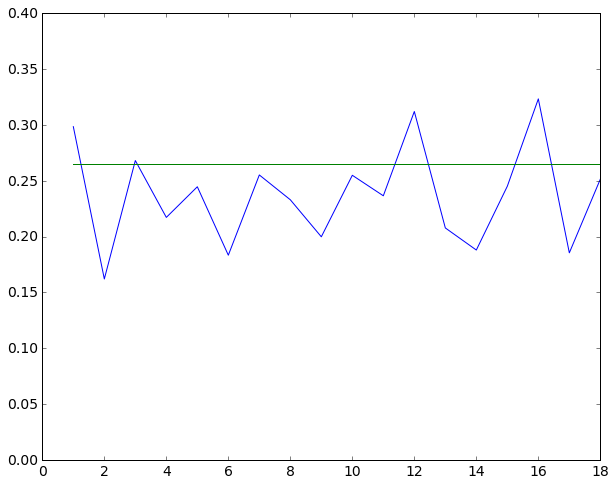

In [12]:
# Fst by MAF in ERY
pylab.plot(range(1, 19), Fst_by_MAF_ery)
pylab.plot(range(1, 19), [sfs2d_unfolded.Fst()] * 18)
pylab.ylim([0, 0.4])

In [13]:
# get Fst by MAF in PAR

Fst_by_MAF_par = np.zeros((18))
n = len(x[1])-1
for i in range(len(Fst_by_MAF_par)):
    j=i+1
    x = np.zeros(sfs2d_unfolded.sample_sizes+1)
    x[j] = sfs2d_unfolded.data.transpose()[j].copy() # note the transpose
    x[(n-j)] = sfs2d_unfolded.data[(n-j)].copy()
    # create new Spectrum object
    y = dadi.Spectrum(data=x, mask=sfs2d_unfolded.mask, data_folded=False, pop_ids=['ery', 'par'])
    Fst_by_MAF_par[i] = y.Fst()

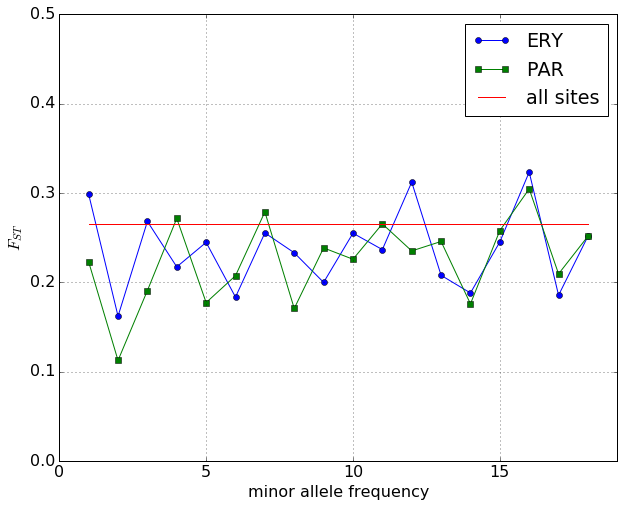

In [123]:
pylab.rcParams['font.size'] = 16
pylab.plot(range(1, 19), Fst_by_MAF_ery, "o-", label="ERY")
pylab.plot(range(1, 19), Fst_by_MAF_par, "s-", label="PAR")
pylab.plot(range(1, 19), [sfs2d_unfolded.Fst()] * 18, label="all sites")
pylab.ylim([0, 0.5])
pylab.xlim([0,19])
pylab.xlabel('minor allele frequency')
pylab.ylabel(r'$F_{ST}$')
pylab.grid()
pylab.legend()
pylab.savefig("Fst_by_MAF.png")

This does not show a clear trend for a reduction in Fst with lower MAF.

### Models

Now I would like to get Fst by MAF for 2D spectra simulated with recent bottleneck or recent expansion in ERY or PAR.

In [ ]:
# setting the smallest grid size slightly larger than the largest population sample size (36)

pts_l = [40, 50, 60]
ns = sfs2d_unfolded.sample_sizes

In [21]:
def test_models(params, ns, pts):

    nu1_1,nu2_1,nu1_2,nu2_2,T1,T2 = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    
    # period of constant population size (T1)
    phi = dadi.Integration.two_pops(phi, xx, T1, nu1_1, nu2_1, m12=0, m21=0)
    
    # period of exponential population size change (T2)
    nu1_func = lambda t: nu1_1 * (nu1_2/nu1_1)**(t/T2)
    nu2_func = lambda t: nu2_1 * (nu2_2/nu2_1)**(t/T2)
    phi = dadi.Integration.two_pops(phi, xx, T2, nu1_func, nu2_func,
                               m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [22]:
# create extrapolating version of the model function

func_ex = dadi.Numerics.make_extrap_log_func(test_models)

#### Bottleneck in ERY

In [84]:
# calculate model spectrum

nu1_1 = 0.6
nu2_1 = 1.2
nu1_2 = nu1_1/10 # ERY final population size ratio
nu2_2 = 1.2
T1 = 0.29 - 0.015
T2 = 0.015 # time of beginning of bottleneck

model_spectrum = func_ex((nu1_1,nu2_1,nu1_2,nu2_2,T1,T2), ns, pts_l)

In [19]:
0.3/20

0.015

In [85]:
# scale the model spectrum to the observed spectrum

ery_bottl_mod = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d_unfolded)

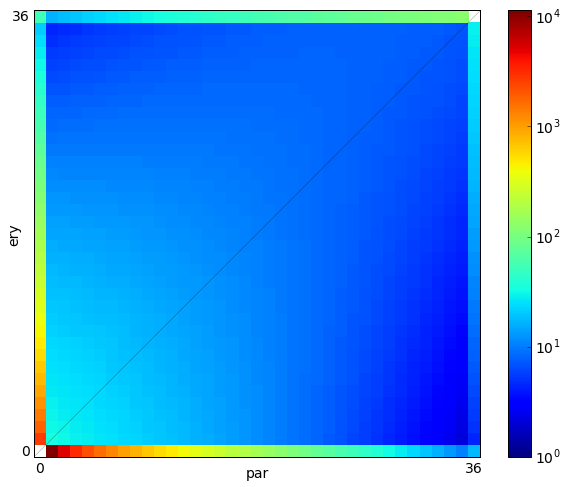

In [86]:
dadi.Plotting.plot_single_2d_sfs(ery_bottl_mod, vmin=1, cmap='jet', pop_ids=['ery', 'par'])

In [87]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_unfolded)

mu = 3e-9
L = sfs2d_unfolded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
#print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ERY and PAR (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

print "The ancestral population of ERY and PAR split apart {0:,} generations ago.".format(int((T1+T2)*2*N_ref)),
print "Since the split until {0:,} generations ago the ERY population had a constant size of {1:,} and the PAR population of {2:,}.".format(int(T2*2*N_ref), int(nu1_1*N_ref), int(nu2_1*N_ref)),
print "{0:,} generations ago, the ERY population began to decreased exponentially to a current population size of {1:,}.".format(int(T2*2*N_ref), int(nu1_2*N_ref))

The effective size of the ancestral population of ERY and PAR (in number of diploid individuals) implied by this theta is: 754,124.
The ancestral population of ERY and PAR split apart 437,391 generations ago. Since the split until 22,623 generations ago the ERY population had a constant size of 452,474 and the PAR population of 904,948. 22,623 generations ago, the ERY population began to decreased exponentially to a current population size of 45,247.


#### Bottleneck in PAR

In [88]:
# calculate model spectrum

nu1_1 = 0.6
nu2_1 = 1.2
nu1_2 = 0.6
nu2_2 = nu2_1/10 # PAR final population size ratio
T1 = 0.29 - 0.015
T2 = 0.015 # time of beginning of bottleneck

model_spectrum = func_ex((nu1_1,nu2_1,nu1_2,nu2_2,T1,T2), ns, pts_l)

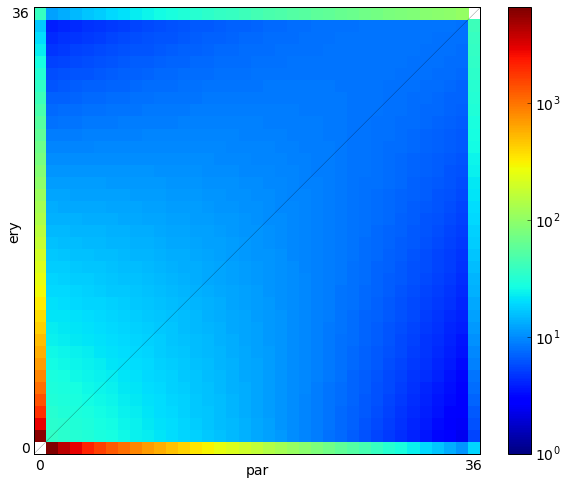

In [89]:
# scale model
par_bottl_mod = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d_unfolded)

# plot model
dadi.Plotting.plot_single_2d_sfs(par_bottl_mod, vmin=1, cmap='jet', pop_ids=['ery', 'par'])

In [90]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_unfolded)

mu = 3e-9
L = sfs2d_unfolded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
#print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ERY and PAR (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

print "The ancestral population of ERY and PAR split apart {0:,} generations ago.".format(int((T1+T2)*2*N_ref)),
print "Since the split until {0:,} generations ago the ERY population had a constant size of {1:,} and the PAR population of {2:,}.".format(int(T2*2*N_ref), int(nu1_1*N_ref), int(nu2_1*N_ref)),
print "{0:,} generations ago, the PAR population began to decreased exponentially to a current population size of {1:,}.".format(int(T2*2*N_ref), int(nu2_2*N_ref))

The effective size of the ancestral population of ERY and PAR (in number of diploid individuals) implied by this theta is: 766,470.
The ancestral population of ERY and PAR split apart 444,552 generations ago. Since the split until 22,994 generations ago the ERY population had a constant size of 459,882 and the PAR population of 919,764. 22,994 generations ago, the PAR population began to decreased exponentially to a current population size of 91,976.


#### Expansion in ERY

In [91]:
# calculate model spectrum

nu1_1 = 0.6
nu2_1 = 1.2
nu1_2 = nu1_1*10.0 # ERY final population size ratio
nu2_2 = 1.2
T1 = 0.29 - 0.015
T2 = 0.015 # time of beginning of bottleneck

model_spectrum = func_ex((nu1_1,nu2_1,nu1_2,nu2_2,T1,T2), ns, pts_l)

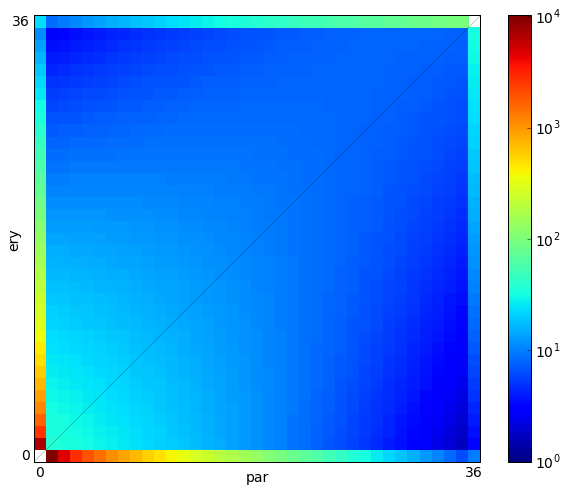

In [92]:
# scale model
ery_exp_mod = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d_unfolded)

# plot model
dadi.Plotting.plot_single_2d_sfs(ery_exp_mod, vmin=1, cmap='jet', pop_ids=['ery', 'par'])

In [93]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_unfolded)

mu = 3e-9
L = sfs2d_unfolded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
# print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

print "The ancestral population of ERY and PAR split apart {0:,} generations ago.".format(int((T1+T2)*2*N_ref)),
print "Since the split until {0:,} generations ago the ERY population had a constant size of {1:,} and the PAR population of {2:,}.".format(int(T2*2*N_ref), int(nu1_1*N_ref), int(nu2_1*N_ref)),
print "{0:,} generations ago, the ERY population began to increase exponentially to a current population size of {1:,}.".format(int(T2*2*N_ref), int(nu1_2*N_ref))

The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 681,870.
The ancestral population of ERY and PAR split apart 395,484 generations ago. Since the split until 20,456 generations ago the ERY population had a constant size of 409,122 and the PAR population of 818,244. 20,456 generations ago, the ERY population began to increase exponentially to a current population size of 4,091,222.


#### Expansion in PAR

In [94]:
# calculate model spectrum

nu1_1 = 0.6
nu2_1 = 1.2
nu1_2 = 0.6
nu2_2 = nu2_1*10.0 # PAR final population size ratio
T1 = 0.29 - 0.015
T2 = 0.015 # time of beginning of bottleneck

model_spectrum = func_ex((nu1_1,nu2_1,nu1_2,nu2_2,T1,T2), ns, pts_l)

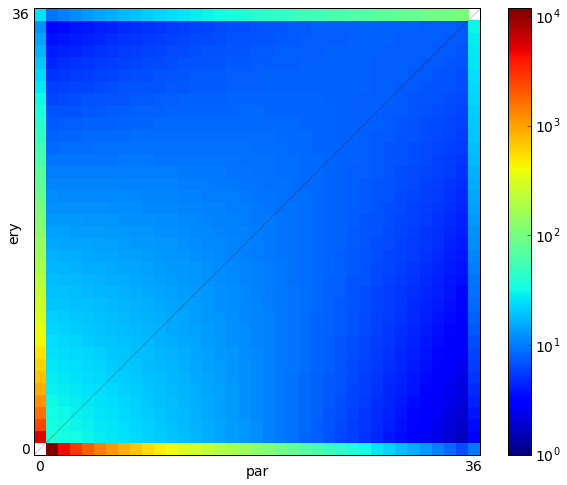

In [95]:
# scale model
par_exp_mod = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d_unfolded)

# plot model
dadi.Plotting.plot_single_2d_sfs(par_exp_mod, vmin=1, cmap='jet', pop_ids=['ery', 'par'])

In [96]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_unfolded)

mu = 3e-9
L = sfs2d_unfolded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
# print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

print "The ancestral population of ERY and PAR split apart {0:,} generations ago.".format(int((T1+T2)*2*N_ref))
print "Since the split until {0:,} generations ago the ERY population had a size of {1:,} and the PAR population of {2:,}.".format(int(T2*2*N_ref), int(nu1_1*N_ref), int(nu2_1*N_ref))
print "{0:,} generations ago, the PAR population began to increase exponentially to a current population size of {1:,}.".format(int(T2*2*N_ref), int(nu2_2*N_ref))

The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 682,567.
The ancestral population of ERY and PAR split apart 395,888 generations ago.
Since the split until 20,477 generations ago the ERY population had a size of 409,540 and the PAR population of 819,080.
20,477 generations ago, the PAR population began to increase exponentially to a current population size of 8,190,806.


### Get Fst by MAF for each model

In [97]:
def get_Fst_by_Maf(model_spectrum):

    # get Fst by MAF in PAR
    Fst_by_MAF_ery = np.zeros((18))
    n = model_spectrum.sample_sizes[0]
    for i in range(len(Fst_by_MAF_ery)):
        j=i+1
        x = np.zeros(model_spectrum.sample_sizes+1)
        x[j] = model_spectrum.data[j].copy()
        x[(n-j)] = model_spectrum.data[(n-j)].copy()
        # create new Spectrum object
        y = dadi.Spectrum(data=x, mask=sfs2d_unfolded.mask, data_folded=False, pop_ids=['ery', 'par'])
        Fst_by_MAF_ery[i] = y.Fst()

    # get Fst by MAF in PAR
    Fst_by_MAF_par = np.zeros((18))
    n = model_spectrum.sample_sizes[1]
    for i in range(len(Fst_by_MAF_par)):
        j=i+1
        x = np.zeros(model_spectrum.sample_sizes+1)
        x[j] = model_spectrum.data.transpose()[j].copy() # note the transpose
        x[(n-j)] = model_spectrum.data[(n-j)].copy()
        # create new Spectrum object
        y = dadi.Spectrum(data=x, mask=sfs2d_unfolded.mask, data_folded=False, pop_ids=['ery', 'par'])
        Fst_by_MAF_par[i] = y.Fst()
        
    return (Fst_by_MAF_ery, Fst_by_MAF_par)    

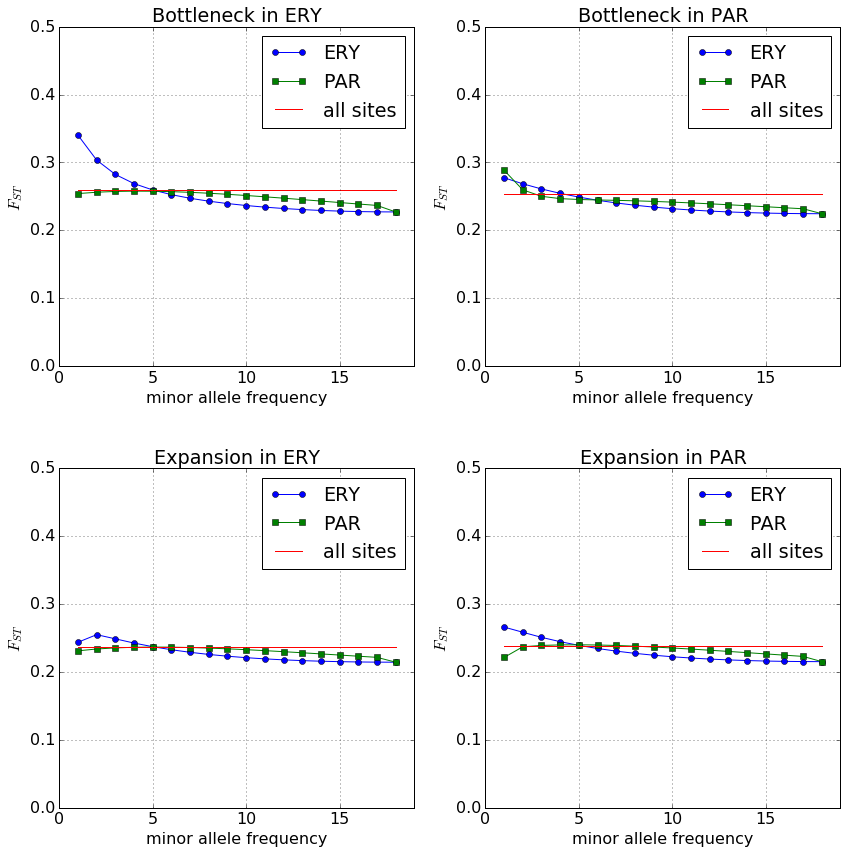

In [124]:
models = [ery_bottl_mod, par_bottl_mod, ery_exp_mod, par_exp_mod]
titles = ['Bottleneck in ERY', 'Bottleneck in PAR', 'Expansion in ERY', 'Expansion in PAR']

pylab.rcParams['figure.subplot.hspace'] = 0.3
pylab.rcParams['figure.subplot.wspace'] = 0.2
pylab.rcParams['font.size'] = 16

pylab.figure(figsize=[14, 14])
for i in range(4):
    ery, par = get_Fst_by_Maf(models[i])
    pylab.subplot(2,2,i+1)
    pylab.plot(range(1, 19), ery, "o-", label="ERY")
    pylab.plot(range(1, 19), par, "s-", label="PAR")
    pylab.plot(range(1, 19), [models[i].Fst()] * 18, label="all sites")
    pylab.ylim([0, 0.5])
    pylab.xlim([0,19])
    pylab.xlabel('minor allele frequency')
    pylab.ylabel(r'$F_{ST}$')
    pylab.grid()
    pylab.legend()
    pylab.title(titles[i])

pylab.savefig("Fst_by_MAF_4Models.png")

This clearly shows the effects of strong bottlenecks or population expansions on the distribution of Fst by MAF.

In [26]:
# get Fst from resampled spectrum
sfs2d_unfolded.scramble_pop_ids().Fst()
# note the resampling is deterministic, i. e. will lead to 1 result only

0.01369863013698628

In [50]:
%psource sfs2d_unfolded.Fst

I have permuted population labels of individual BAM files and calculated a 2D SFS for each of 100 permutations (see `assembly.sh`, line 1502 onwards).

In [5]:
from glob import glob

# read in 100 2D SFS with permuted population labels
permut_sfs2d = [dadi.Spectrum.from_file(sfs) for sfs in glob("../ANGSD/FST/Bootstrap/*dadi")]

In [6]:
# calculate Weir & Cockerham's Fst for the permuted SFS's

permut_Fst = [sfs.Fst() for sfs in permut_sfs2d]

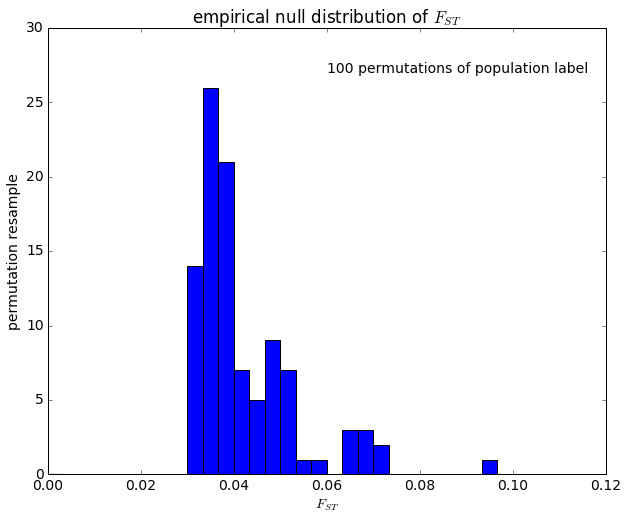

In [18]:
# plot a histogram of the permuted Fst's

pylab.hist(permut_Fst, bins=30, range=[0.0, 0.1])
pylab.xlabel(r'$F_{ST}$')
pylab.ylabel('permutation resample')
pylab.title('empirical null distribution of ' + r'$F_{ST}$')
pylab.text(0.06, 27, '100 permutations of population label')
pylab.savefig("Fst_dadi_perm_null_dist.png")

In [13]:
pylab.text?

In [49]:
# get the median Fst from permuted SFS's

pylab.median(permut_Fst)

0.037367723086801127

I would have expected that the median Fst from permuted SFS's is zero. Instead there seems to be a positive bias in the Fst of 0.037. I have also found a bias of very similar magnitude with Bhatia's Fst as estimated by `realSFS`.

In [8]:
sfs2d_folded = sfs2d_unfolded.fold()

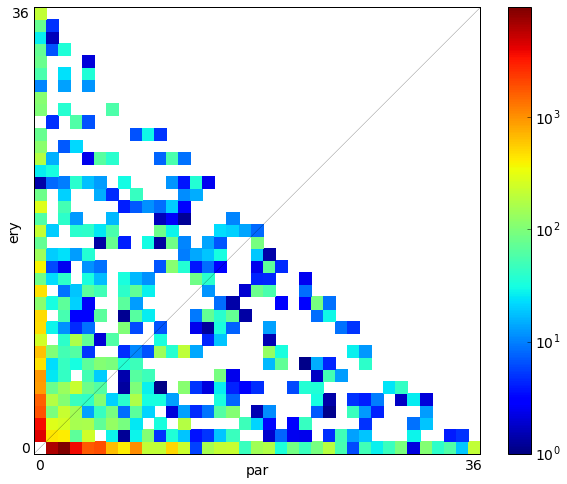

In [13]:
# plot the folded GLOBAL minor allele frequency spectrum

dadi.Plotting.plot_single_2d_sfs(sfs2d_folded, vmin=1, cmap='jet')

In [9]:
# push sfs to remote engines

cl[:].push(dict(sfs2d_folded=sfs2d_folded))

<AsyncResult: _push>

## marginal spectra

In [16]:
sfs2d_folded.marginalize?

In [14]:
sfs2d_folded.pop_ids

['ery', 'par']

In [15]:
# get marginal spectra

par_sfs_marg = sfs2d_unfolded.marginalize([0])
ery_sfs_marg = sfs2d_unfolded.marginalize([1])

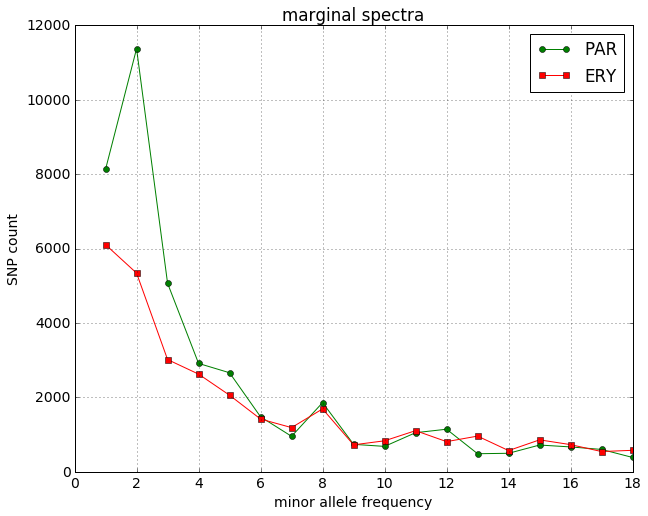

In [16]:
pylab.plot(par_sfs_marg.fold(), 'go-', label='PAR')
pylab.plot(ery_sfs_marg.fold(), 'rs-', label='ERY')
pylab.xlabel('minor allele frequency')
pylab.ylabel('SNP count')
pylab.title('marginal spectra')
pylab.grid()
pylab.legend()

These are the 1D spectra for ERY and PAR from sites where _both_ populations had reads from at least 9 individuals.

In [17]:
print "The number of sites in each marginal spectrum is: {0:,}".format(int(np.sum(sfs2d_unfolded.data)))

The number of sites in each marginal spectrum is: 1,130,775


In [18]:
# number of segregating sites in the PAR spectrum

par_sfs_marg.S()

41419.868926000003

In [19]:
# number of segregating sites in the ERY spectrum

ery_sfs_marg.S()

31162.384933000001

The PAR spectrum contains 10k more SNP's than the ERY spectrum.

In [20]:
par_sfs_marg.pi()

8342.5224928333319

In [21]:
ery_sfs_marg.pi()

7407.1233099158717

In [22]:
# calculate pi_site for ERY

ery_sfs_marg.pi()/sfs2d_unfolded.data.sum()

0.0065504837919977167

In [23]:
# calculate pi_site for PAR

par_sfs_marg.pi()/sfs2d_unfolded.data.sum()

0.0073777033386935482

These two values of $\pi_{site}$ are practically the same as their equivalents calculated from 1D unfolded spectra estimated from all sites with reads in at least 9 individuals in the focal population (i. e. including non-overlapping sites):

In [1]:
import numpy as np

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [24]:
# import 1D unfolded spectrum for each pop

ery_unfolded = dadi.Spectrum.from_file('ERY.unfolded.sfs')

par_unfolded = dadi.Spectrum.from_file('PAR.unfolded.sfs')

In [25]:
print "Size of ERY 1D spectrum: {0:,}.".format(int(np.sum(ery_unfolded.data)))
print "Size of PAR 1D spectrum: {0:,}.".format(int(np.sum(par_unfolded.data)))

Size of ERY 1D spectrum: 1,638,467.
Size of PAR 1D spectrum: 1,214,938.


In [27]:
print "{0:.6f}".format(ery_unfolded.pi()/ery_unfolded.data.sum())

0.006530


In [28]:
print "{0:.6f}".format(par_unfolded.pi()/par_unfolded.data.sum())

0.007313


The fact that the total sequence length for the ERY 1D spectrum is 1,638,467 and the total sequence length for the PAR spectrum is only 1,214,938 does lead _not_ to significantly different estimates of $\pi_{site}$. The overlapping sites between the two population samples show practically the same $\pi_{site}$ as when calculated from all sites of each population. The higher genetic diversity in PAR as compared to ERY is therefore not due to a relative enrichment in PAR (due to minimum coverage filtering) of sites less affected by allele dropout.

## preparation

In [10]:
# setting the smallest grid size slightly larger than the largest population sample size (36)

pts_l = [40, 50, 60]
ns = sfs2d_folded.sample_sizes

In [ ]:
%pinfo dadi.Demographics2D.split_mig

The 1D model fitting has indicated that both _erythropus_ and _parallelus_ underwent population size reduction, maybe starting a long time ago (>400,000 generations).

In [17]:
%psource dadi.Demographics2D.split_mig

In [18]:
%psource dadi.Integration.two_pops

# simple divergence model

In [12]:
def split_nomig(params, ns, pts):
    """
    params = (nu1,nu2,T)
    ns = (n1,n2)

    Split into two populations of specifed size, no migration.

    nu1: Size ratio of population 1 after split (with respect to ancestral population size Na)
    nu2: Size ratio of population 2 after split (with respect to ancestral population size Na)
    T: Time in the past of split (in units of 2*Na generations) 
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,T = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)

    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [13]:
cl[:].push(dict(split_nomig=split_nomig))

<AsyncResult: _push>

In [18]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [15]:
%%px --local

func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [16]:
# push folded spectrum to all engines

cl[:].push(dict(sfs2d_folded=sfs2d_folded))

<AsyncResult: _push>

In [17]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d_folded
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 10 # run a maximum of 10 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_nomig" # set file name stub for opt. result files

Ryan Gutenkunst writes on the dadi forum:
> The parameter bounds are primarily about avoiding really slow fits. Calculation with high migration rates and times or small population sizes is much slower, and the optimizer can explore extreme values before settling down. So typically we set migrations rates to be bounded [0, 20ish], times to be [0, 5ish], population sizes to be [1e-3, 1e6ish].

In [18]:
%%px --local

# set lower and upper bounds to nu1, nu2 and T
upper_bound = [1e4, 1e4, 5]
lower_bound = [1e-4, 1e-4, 0]

ns = sfs2d_folded.sample_sizes # both populations have the same sample size

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

Run locally:

In [26]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.5] # split into equal proportions at >200,000 generations ago

#run_dadi(p0)

It works.

In [29]:
lbview = cl.load_balanced_view()

In [30]:
from itertools import repeat

In [31]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.5] # split into equal proportions at >200,000 generations ago

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [27]:
def get_flag_count(out, NM=True):
    """
    out: list of tuples, each containing p_init and popt + additional info, including warnflags
    as produced by run_dadi.py
    """
    from collections import defaultdict
    
    if NM: # if ar from Nelder-Mead
        i = 4 # the warnflag is reported at index position 4 in the output array
    else: # ar from BFGS optimisation
        i = 6
    
    warnflag = defaultdict(int)

    for res in out:
        if res[1][i] == 1: # notice the change in indexing
            warnflag[1] +=1
        elif res[1][i] == 2:
            warnflag[2] += 1
        elif res[1][i] == 0:
            warnflag[0] += 1
        else:
            warnflag[999] +=1
    if NM:
        print "success", warnflag[0]
        print "Maximum number of function evaluations made.", warnflag[1]
        print "Maximum number of iterations reached.", warnflag[2]
        print "unknown flag", warnflag[999]
    else:
        print "success", warnflag[0]
        print "Maximum number of iterations exceeded.", warnflag[1]
        print "Gradient and/or function calls not changing.", warnflag[2]
        print "unknown flag", warnflag[999]

In [34]:
get_flag_count(ar_split_nomig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [35]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.1] # split into equal proportions at >200,000 generations ago

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [36]:
get_flag_count(ar_split_nomig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [37]:
%%px

maxiter = 100

In [38]:
# perturb parameter neutral values
p0 = [0.5, 0.5, 0.1] # split into equal proportions at >200,000 generations ago

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [48]:
ar_split_nomig_1.wall_time

40.304026

In [39]:
get_flag_count(ar_split_nomig_1, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


In [19]:
def flatten(array):
    """
        Returns a list of flattened elements of every inner lists (or tuples)
        ****RECURSIVE****
    """
    import numpy
    res = []
    for el in array:
        if isinstance(el, (list, tuple, numpy.ndarray)):
            res.extend(flatten(el))
            continue
        res.append(el)
    return list( res )

In [20]:
import pandas as pd

In [43]:
success = [flatten(out)[:7] for out in ar_split_nomig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
3,0.146030,1.659384,0.282181,0.637644,1.229881,0.290447,20387.435816
2,0.201540,0.651162,0.031593,0.637639,1.229858,0.290441,20387.435817
0,0.533901,0.839080,0.139849,0.637653,1.229835,0.290444,20387.435818
4,0.218471,1.740969,0.295402,0.637657,1.229890,0.290440,20387.435819
1,0.147376,0.642951,0.091625,0.637672,1.229838,0.290449,20387.435820
5,0.277689,1.509007,0.044130,0.637684,1.229796,0.290440,20387.435837


In [49]:
%%px

fold = 3 # increase perturbation factor

In [50]:
# perturb parameter neutral values
p0 = [0.637644, 1.229881, 0.29] # use previous optimal parameter values

#ar_split_nomig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [51]:
get_flag_count(ar_split_nomig_1, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


In [52]:
success = [flatten(out)[:7] for out in ar_split_nomig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
4,0.877109,0.741007,0.360840,0.636945,1.229606,0.290465,20387.227270
1,0.136711,7.063745,0.075557,0.637653,1.229853,0.290442,20387.435815
2,1.461323,4.088909,2.236886,0.637660,1.229850,0.290445,20387.435815
3,0.854249,1.682438,0.240684,0.637655,1.229849,0.290445,20387.435815
5,0.324028,1.847701,0.160416,0.637682,1.229931,0.290459,20387.435816
0,0.248861,4.984686,0.085569,0.637683,1.229911,0.290450,20387.435817


The optimal parameter values look very robust: very different starting values converge to almost identical optimal parameter values.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [12]:
from glob import glob
import dill

In [22]:
ar_split_nomig = []

for filename in glob("OUT_2D_models/split_nomig*dill"):
    ar_split_nomig.append(dill.load(open(filename)))

In [23]:
# get final parameter values from "unsuccessfull" optimisations
returned = [flatten(out)[:7] for out in ar_split_nomig if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T_0', 'nu1_opt', 'nu2_opt', 'T_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,nu1_opt,nu2_opt,T_opt,-logL
6,0.175658,1.424901,0.091189,0.637435,1.232050,0.290688,20387.233020
15,4.009909,4.025002,1.183326,0.634830,1.228691,0.289500,20387.282947
3,0.970956,0.347585,0.106654,0.637649,1.229815,0.290410,20387.435897
26,1.276182,0.720070,0.063780,0.637677,1.229687,0.290454,20387.435980
9,0.939690,1.972600,0.071647,0.637896,1.229568,0.290435,20387.436683
12,0.881059,0.204774,0.038037,0.638187,1.227018,0.289774,20387.481281
0,0.646744,0.686350,0.652774,0.769909,1.456982,0.322940,20553.979611
7,0.622374,1.623001,0.235626,0.581536,1.635792,0.300698,20884.101605
1,0.371096,0.287767,0.429379,0.423534,1.000000,0.230989,20989.179991
19,0.297561,0.279895,0.339821,0.349757,0.712085,0.177828,21595.045797


There are no better parameter combinations among the results from "unsuccessfull" optimisations.

## Interpretation

In [55]:
# calculate best-fit model spectrum

model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

In [56]:
# log likelihood of the observed 2D spectrum given the model

ll_model = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [57]:
ll_model

-20387.227246474409

The negative log likelihood of the data given the model is also returned by the full output of the optimisation function (as used above).

In [58]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)

In [65]:
print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))

The optimal value of theta is 9347.


In [66]:
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 688,875.


In [72]:
sfs2d_folded.pop_ids

['ery', 'par']

I am assuming that $\nu_1$ refers to _ery_ and $\nu_2$ refers to _par_. The `split_nomig` model with its optimal parameter values suggests the following:

In [77]:
print "The ancestral population of ery and par split apart {2:,} generations ago. Since then until present the ery population had a size of {0:,} and the par population of {1:,}.".format(int(0.636945*N_ref), int(1.229606*N_ref)
, int(0.290465*2*N_ref))

The ancestral population of ery and par split apart 400,188 generations ago. Since then until present the ery population had a size of 438,776 and the par population of 847,045.


Note, that the fitting of 1D models to the spectra of each population had indicated a population size reduction for both populations and more so for _parallelus_, which seems to contradict what this 2D model says about the two populations.

## plot residuals

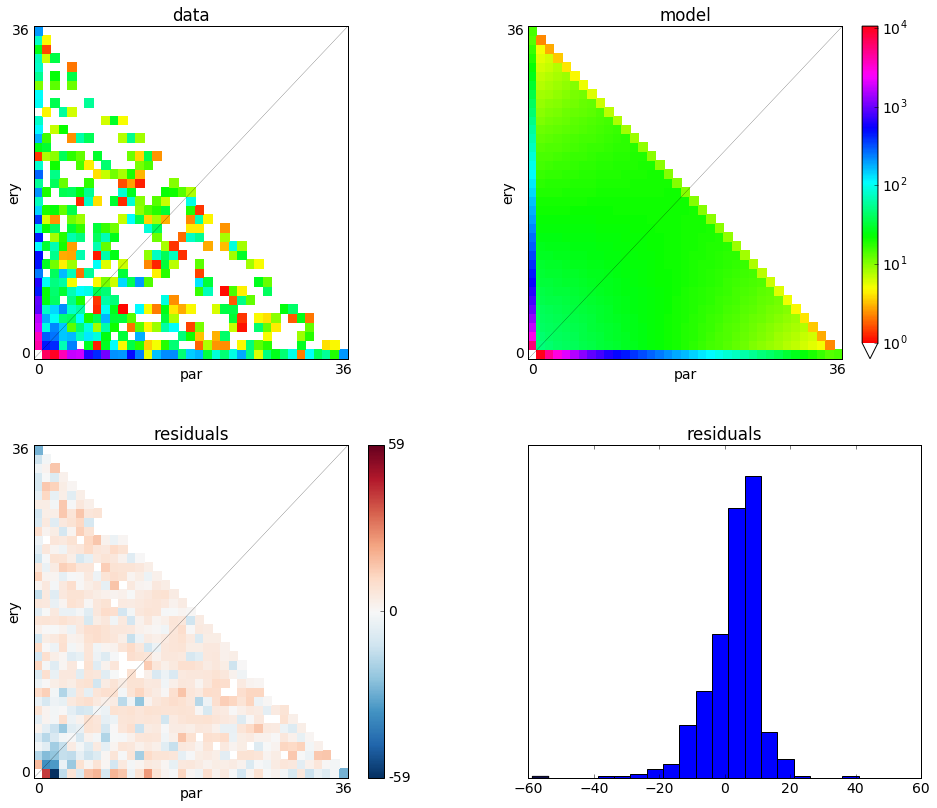

In [79]:
import pylab

pylab.rcParams['figure.figsize'] = [14.0, 12.0]
pylab.rcParams['font.size'] = 14.0

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

A good computer screen is required to see the heatmap of the residuals in full detail.

The residuals show that the best-fit model has a deficit of fixed divergent SNP's as well as of low frequency shared SNP's close to the diagonal.

Maybe the fit can be improved by introducing gene flow.

# divergence with migration model

In [156]:
?dadi.Demographics2D.split_mig

In [30]:
%%px --local

func = dadi.Demographics2D.split_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [33]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d_folded
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 10 # run a maximum of 10 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_mig" # set file name stub for opt. result files

In [26]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m
upper_bound = [1e4, 1e4, 2, 10]
lower_bound = [1e-4, 1e-4, 0, 0]

In [34]:
# perturb these parameter values
# nu1, nu2, T, m
p0 = [0.5, 0.5, 0.1, 0.1] 
# split into equal proportions at >200,000 generations ago with 1 migrant individual per 10 generations

#ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [85]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [86]:
%%px

fold = 3 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 10 iterations

In [87]:
# perturb these parameter values
p0 = [0.5, 0.5, 0.1, 0.1] 
# split into equal proportions at >200,000 generations ago with migrant one individual per 10 generations

#ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [88]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [91]:
# perturb these parameter values
p0 = [0.5, 0.5, 0.1, 0.01] 
# split into equal proportions at >200,000 generations ago with one migrant individual per 100 generations

#ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [92]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [93]:
# optimal parameters for nomig model: (0.636945, 1.229606, 0.290465)

# perturb parameter neutral values
p0 = [0.636945, 1.229606, 0.290465, 0.01] 
# split into equal proportions at >200,000 generations ago with migrant individual per 100 generations

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [94]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [95]:
import numpy as np

In [97]:
m0 = np.logspace(-3, np.log10(5), base=10, num=20)
m0

array([  1.00000000e-03,   1.56560656e-03,   2.45112389e-03,
         3.83749564e-03,   6.00800835e-03,   9.40617727e-03,
         1.47263728e-02,   2.30557058e-02,   3.60961643e-02,
         5.65123915e-02,   8.84761707e-02,   1.38518873e-01,
         2.16866056e-01,   3.39526920e-01,   5.31565572e-01,
         8.32222546e-01,   1.30293308e+00,   2.03988057e+00,
         3.19365039e+00,   5.00000000e+00])

In [98]:
from itertools import product

In [109]:
p0 = [0.636945, 1.229606, 0.290465]

# do parameter sweep for migration rate
#ar_split_mig_1 = lbview.map(run_dadi, [p0 + [m] for m in m0], block=False, order=False)

In [112]:
ar_split_mig_1.progress

19

In [113]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 20
unknown flag 0


In [116]:
p0 = [0.636945, 1.229606, 0.290465, 1e-6]

#ar_split_mig_1 = lbview.map(run_dadi, [p0], block=False, order=False)

In [117]:
get_flag_count(ar_split_mig_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 1
unknown flag 0


In [118]:
ar_split_mig_1.get()

[(array([  5.67647408e-01,   8.28132232e+00,   2.79617129e-01,
           7.13792423e-06]),
  (array([  6.37632787e-01,   1.22989019e+00,   2.90446980e-01,
            5.49800562e-07]), 20387.430473918725, 100, 178, 2))]

In [119]:
p0 = [0.636945, 1.229606, 0.290465, 1e-8]

#ar_split_mig_1 = lbview.map(run_dadi, [p0], block=False, order=False)

In [120]:
ar_split_mig_1.get()

[(array([  4.69103735e+00,   6.98005316e+00,   2.34055747e-01,
           4.71573909e-09]),
  (array([  6.36962650e-01,   1.22844256e+00,   2.89937795e-01,
            9.28295473e-21]), 20387.445239922406, 100, 169, 2))]

In [122]:
%%px

maxiter = 500

In [123]:
# nu1, nu2, T, m:
p0 = [0.5, 0.5, 0.1, 1e-4]

ar_split_mig_1 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=False)

In [124]:
get_flag_count(ar_split_mig_1, NM=True)

success 18
Maximum number of function evaluations made. 2
Maximum number of iterations reached. 0
unknown flag 0


Apparently, convergence of optimisation requires many more than 100 iterations.

In [125]:
success = [flatten(out)[:9] for out in ar_split_mig_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
3,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
15,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801
14,1.009844,1.115355,0.012909,0.000309,0.992355,1.760054,0.901086,2.470464e-01,18574.974381
7,0.409099,0.405881,0.168447,0.000052,0.637198,1.230384,0.290581,6.497219e-08,20387.225419
11,2.175460,0.556770,0.086338,0.000014,0.637198,1.230385,0.290581,1.748376e-20,20387.226053
5,0.265271,0.129476,0.157514,0.000045,0.637196,1.230384,0.290580,2.583554e-12,20387.226053
6,0.085281,0.402881,0.364705,0.000042,0.637198,1.230385,0.290581,3.044384e-18,20387.226053
9,0.115098,0.103779,0.172020,0.000113,0.637162,1.230734,0.290565,4.850122e-15,20387.226666
17,3.731189,0.119188,0.015205,0.000017,0.637549,1.230015,0.290740,9.454649e-15,20387.229881
13,1.308999,0.089865,0.482895,0.000052,0.636599,1.228599,0.290307,4.483462e-10,20387.232239


The first three parameter combinations are much more likely than the remaining ones.

In [126]:
# extract optimal parameter combination

df.sort_values(by='-logL', ascending=True).iloc[0, 4:8]

nu1_opt    0.996572
nu2_opt    1.771058
T_opt      0.928727
m_opt      0.250889
Name: 3, dtype: float64

In [128]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

#ar_split_mig_2 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=False)

In [129]:
ar_split_mig_2.progress

19

In [132]:
ar_split_mig_2.elapsed/60

25.53058113333333

In [16]:
import numpy as np
import pandas as pd
from utility_functions import *

In [3]:
import dill, glob

ar_split_mig_2 = []

for filename in glob.glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig_2.append(dill.load(open(filename)))

In [4]:
success = [flatten(out)[:9] for out in ar_split_mig_2 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
8,2.059032,0.360002,0.682463,0.192790,0.994185,1.766127,0.922632,2.506880e-01,18574.119915
31,0.620927,0.849787,1.980000,1.827165,0.994247,1.766242,0.922690,2.507990e-01,18574.120405
2,2.894370,11.363772,1.980000,0.272765,0.993365,1.764405,0.921871,2.509119e-01,18574.121486
28,0.631049,2.924698,0.247732,0.205392,0.993307,1.765318,0.921817,2.509740e-01,18574.122241
17,0.837500,2.063526,0.058201,0.000110,0.996572,1.771058,0.928727,2.508888e-01,18574.138486
18,5.535163,3.398472,0.309525,0.169667,0.993863,1.767477,0.925657,2.517209e-01,18574.159471
15,0.318463,0.315764,0.587406,1.138654,0.989922,1.761280,0.914716,2.507331e-01,18574.164848
1,0.277233,8.221059,0.976626,0.051974,1.001148,1.776879,0.937823,2.505879e-01,18574.226541
0,5.653430,3.362330,1.980000,0.101259,0.995994,1.769480,0.927834,2.507786e-01,18574.341908
33,0.208178,2.525835,0.609693,0.000767,0.997653,1.771560,0.931469,2.510613e-01,18574.373801


Parameter combinations with neg. log likelihood of 20387 are almost identical to the `split-no-migration` from above. Adding some gene flow improves the likelihood of the model.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [36]:
import dill
from glob import glob

In [42]:
ar_split_mig = []

for filename in glob("OUT_2D_models/split_mig_[0-9]*dill"):
    ar_split_mig.append(dill.load(open(filename)))

In [43]:
# get "unsuccessfull" optimisations
returned = [flatten(out)[:9] for out in ar_split_mig if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T_0,m_0,nu1_opt,nu2_opt,T_opt,m_opt,-logL
40,0.810084,1.218102,0.547376,0.247139,0.991729,1.763794,0.920356,0.251048,18574.132734
37,0.489094,1.037535,0.132257,0.000176,0.989262,1.756507,0.914103,0.251147,18574.172032
0,1.494576,6.954689,0.542031,0.010270,0.984775,1.749987,0.906018,0.251081,18574.291695
49,0.299664,0.357796,0.174061,0.291803,0.996390,1.773132,0.929317,0.251732,18574.431565
30,0.500123,0.224216,0.050188,0.236097,0.985358,1.750439,0.909906,0.253170,18574.527262
34,0.688407,2.368404,0.492408,0.024299,1.007132,1.769779,0.941429,0.250509,18574.908052
52,1.014963,0.091473,0.018470,0.165964,1.025306,1.806740,0.963090,0.246319,18575.665086
27,0.258895,1.496689,0.135203,5.109754,1.006629,1.791963,0.942875,0.254426,18576.258223
62,0.240427,1.288769,0.019360,0.063827,0.958215,1.690832,0.868486,0.256389,18577.123050
59,2.097444,2.629962,0.281612,1.580978,1.041270,1.831819,0.981282,0.244224,18577.123802


There are no better parameter combinations than the ones already seen.

In [5]:
df.sort_values(by='-logL', ascending=True).iloc[0, 4:8]

nu1_opt    0.994185
nu2_opt    1.766127
T_opt      0.922632
m_opt      0.250688
Name: 8, dtype: float64

In [44]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 4:8])

In [47]:
# calculate best-fit model spectrum

model_spectrum = func_ex(popt, ns, pts_l)

In [48]:
# log likelihood of the observed 2D spectrum given the model

ll_model = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)

In [49]:
ll_model

-18574.132733558956

In [50]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d_folded)
theta

6364.0471152999226

In [51]:
mu = 3e-9
L = sfs2d_folded.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 469,003.


## plot

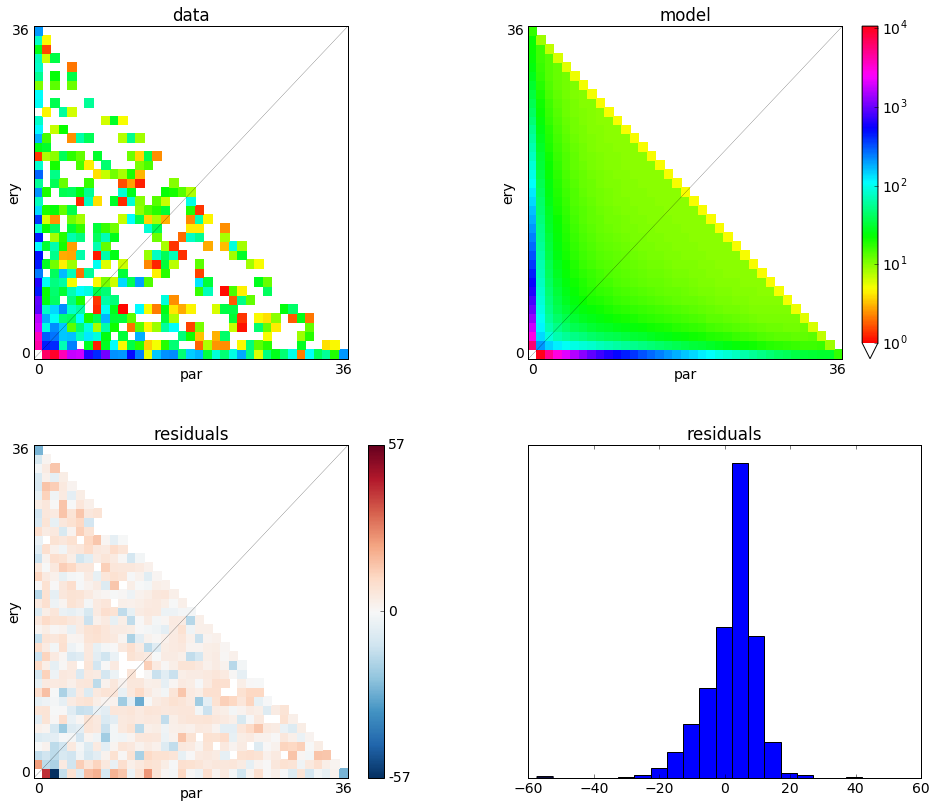

In [145]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d_folded, vmin=1)

This has reduced the residuals for low frequency shared polymorphisms, but the model still cannot fit divergently fixed SNP's well.

## Translation of _m_

The dadi manual says about the migration rate parameter (on page 11):

>The migration parameter m12 specifies the rate of migration from pop 2 into pop 1. It is equal to the _fraction of individuals_ each generation in pop 1 that are new migrants from pop 2, times the 2Nref.

So the fraction of new immigrant alleles each generation from $pop_2$ in $pop_1$ is:
$$
p_{m12} = \frac{m_{12}}{2N_{ref}}
$$

Since dadi's migration rate is scaled by 2Nref, the migration rate parameter as reported by dadi has units of _immigrant individuals per generation_ for a diploid locus. However, whenever pop 1 does not have the same size as the ancestral population ($N_{ref}$}, dadi's $m_{12}$ needs to be rescaled by multiplication with $\nu_1$ to get the number of new immigrant individuals per generation ($M_{12}$):

$$
\begin{align}
M_{12} &= p_{m12} \times 2N_{ref}\nu_1 \\[5pt]
M_{12} &= \nu_1 m_{12}
\end{align}
$$


See this [confirm units of dadi](https://groups.google.com/forum/#!searchin/dadi-user/Nref%7Csort:relevance/dadi-user/AY_4NoEjsx8/eamGdb39AwAJ) thread on the dadi forum.

The way I calculate Nref from theta here, I get the Nref in units of diploid individuals:

>For haploid data, you can replace all factors of 2*Nref with Nref. So it would be Nref = (theta)/(2*mu*L). The same adjustment would be needed for converting times and rates of gene flow.

Ryan Gutenkunst on dadi forum post [Calculating Nref for haploid data](https://groups.google.com/forum/#!searchin/dadi-user/Nref%7Csort:relevance/dadi-user/3oT3E_7l0Mw/Iq0qWc8n5akJ).

What does this model fit says in plain English:

In [54]:
print "The ancestral population split apart {0:,} generation ago.".format(int(popt[2]*2*N_ref)), 
print "Since then, ery and par had a constant population size of {0:,} and {1:,}, respectively.".format(int(popt[0]*N_ref), int(popt[1]*N_ref)), 
print "Since the split, a fraction of {0:.2e} of the population size each generation were made up of new immigrant individuals from the other subspecies.".format(popt[3]/2/N_ref),
print "Put another way:",
print "Since the split ery received a constant number of {0:.2f} new immigrant alleles per generation, while par received a constant number of {1:.2f} per generation.".format(popt[3]*popt[0], popt[3]*popt[1])

The ancestral population split apart 864,128 generation ago. Since then, ery and par had a constant population size of 465,572 and 827,069, respectively. Since the split, a fraction of 2.68e-07 of the population size each generation were made up of new immigrant individuals from the other subspecies. Put another way: Since the split ery received a constant number of 0.25 new immigrant alleles per generation, while par received a constant number of 0.44 per generation.


## LRT

Is the model *with* migration significantly better than the model *without* migration?

From the dadi manual:

>The full likelihood ratio test statistic is equal to $D = 2(ll_c - ll_s)$ where $ll_c$ and $ll_s$ are the likelihoods of the complex and simple model, respectively.

$D$ should be $\chi^2$ distributed

>with degrees of freedom equal to the difference in number of parameters between the simple and complex model.

Not all SNP's in the spectrum will be unlinked with each other. Therefore, the *likelihoods* calculated are *composite likelihoods*. Dadi can calculate an adjustment factor for $D$ that corrects for linkage. However, this requires bootstrapped data sets, which I haven't created yet. In the following calculation I am assuming that all SNP's can be assumed independent data points.

In [56]:
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)
ll_c

-18574.119915473293

In [59]:
func = split_nomig

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

# calculate best-fit model spectrum with optimal parameter values
model_spectrum = func_ex((0.636945, 1.229606, 0.290465), ns, pts_l)

ll_s = dadi.Inference.ll_multinom(model_spectrum, sfs2d_folded)
ll_s

-20387.227246474409

In [60]:
D = 2*(ll_c - ll_s)
D

3626.2146620022322

From the dadi example script `YRI_CEY.py`:

>Because this is a test of a parameter on the boundary of the parameter space 
(m cannot be less than zero), our null distribution is an even proportion 
of chi^2 distributions with 0 and 1 d.o.f. To evaluate the p-value, we use the
point percent function for a weighted sum of chi^2 dists.

See Self2007 for more complex cases.

In [61]:
# calculate p-value
p = dadi.Godambe.sum_chi2_ppf(D, weights = (0.5, 0.5))
p

0.0

Gene flow significantly improves the fit to the observed spectrum. I doubt that there could be enough linkage in the data to compromise this result.

# Recent secondary contact model

Phylogeographic studies as well as paleoclimatic data strongly suggest that the two subspecies, _erythropus_ and _parallelus_, diverged in isolation during at least the last ice age and only recently (~10,000 YBP) came into secondary contact. Clines of several morphological as well as molecular markers have been shown to be very wide, which indicates substantial gene flow across the hybrid zone into adjacent pure populations. The two population samples come from such "pure" populations in close proximity to the hybrid zone. They may therefore show evidence of _recent_ gene flow between the two subspecies.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [41]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

sfs2d = sfs2d_unfolded.fold()

In [42]:
sfs2d.sample_sizes

array([36, 36])

In [43]:
%%px --local

sfs2d.pop_ids = ['ery', 'par']

I am now defining a model function that is a mixture of the `split_nomig` and `split_mig` models. It specifies a split, divergence in isolation for a time $T_i$, then secondary contact of the two diverged populations since $T_c$ times $2N_{ref}$ generations in the past.

In [6]:
def secondary_contact(params, ns, pts):
    """
    params = (nu1,nu2,Ti,Tc,m)
    ns = (n1,n2)

    Split into two populations of specified size, 
    then diverge in isolation,
    finally come into secondary contact.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    Ti: Time of divergence in isolation (in units of 2*Na generations)
    Tc: Time in the past when secondary contact began (and continues till present)
    m: symmetrical migration rate (in units of 2*Na per generation)
    
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,Ti,Tc,m = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) # split

    # divergence in isolation
    phi = dadi.Integration.two_pops(phi, xx, Ti, nu1, nu2, m12=0, m21=0) 
    
    # secondary contact
    phi = dadi.Integration.two_pops(phi, xx, Tc, nu1, nu2, m12=m, m21=m)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [7]:
# push model function into namespace of remote engines

cl[:].push(dict(secondary_contact=secondary_contact))

<AsyncResult: _push>

In [18]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [8]:
%%px --local

func = secondary_contact

# create extrapolating version of the model function
func_ex = dadi.Numerics.make_extrap_log_func(func)

In [20]:
%%px --local

# set up global variables on engines required for run_dadi function call

dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 100 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/sec_contact" # set file name stub for opt. result files

In [9]:
%%px --local

# set lower and upper bounds to nu1, nu2, Ti, Tc and m
upper_bound = [1e4, 1e4, 5, 5, 10]
lower_bound = [1e-4, 1e-4, 0, 0, 0]

ns = sfs2d.sample_sizes # both populations have the same sample size

# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]

In [13]:
# perturb these parameter values for starting value generation
p0 = [1, 1.5, 0.9, 0.1, 1]
# nu_1, nu_2, Ti, Tc, m

# run locally
run_dadi(p0)

(array([ 0.32912152,  1.74859714,  0.49916884,  0.27947294,  2.53155626]),
 (array([ 0.6746985 ,  1.38442775,  0.36257617,  0.02475325,  0.65765189]),
  19457.799214498067,
  100,
  158,
  2))

The code works in principle. However, the upper optimisation did not converge (flag==2).

In [16]:
lbview = cl.load_balanced_view()

In [17]:
from itertools import repeat

In [18]:
# perturb parameter neutral values
p0 = [ 0.6746985 ,  1.38442775,  0.36257617,  0.02475325,  0.65765189] 
# although the single optimisation above was not successfull (flag==2), 
# I am using its returned values as starting values for perturbation

#ar_sec_contact_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [10]:
from utility_functions import *

In [20]:
get_flag_count(ar_sec_contact_1, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


In [22]:
%%px

# increase the maximum number of iterations
maxiter = 300

In [23]:
# perturb parameter neutral values
p0 = [ 0.6746985 ,  1.38442775,  0.36257617,  0.02475325,  0.65765189] 
# although the single optimisation above was not successfull (flag==2), 
# I am using its returned values as starting values for perturbation

#ar_sec_contact_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [33]:
# get total running time in minutes
ar_sec_contact_1.wall_time/60

15.04222375

In [24]:
get_flag_count(ar_sec_contact_1, NM=True)

success 5
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 5
unknown flag 0


5 runs succeeded, 5 hit the maxiter limit.

In [11]:
import pandas as pd

In [36]:
success = [flatten(out)[:11] for out in ar_sec_contact_1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
1,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
4,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
0,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
2,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
3,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


The second parameter combination from the bottom is the closest to a `recent-secondary-contact` model, but it has slightly lower likelihood than models that specify a much longer time of secondary contact ($T_c$).

In [14]:
import numpy as np

In [ ]:
# extract best parameter combination
pset = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,5:10])

In [32]:
# perturb from best parameter combination
p0 = pset

#ar_sec_contact_2 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [34]:
get_flag_count(ar_sec_contact_2, NM=True)

success 3
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 7
unknown flag 0


Only 3 runs succeeded.

In [37]:
# add output from successfull runs to table

success.extend([flatten(out)[:11] for out in ar_sec_contact_2 if out[1][4] == 0])

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
7,1.236540,2.847184,0.230733,3.068632,0.849626,0.995633,1.767191,0.089521,0.836080,0.251181,18574.175975
5,1.006920,2.471800,0.560705,1.489177,0.540249,1.007125,1.785494,0.144681,0.789880,0.249414,18574.820474
6,4.600362,4.057741,0.163307,1.080377,0.070965,1.128504,1.983990,0.054273,1.143632,0.239594,18596.261482
1,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
4,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
0,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
2,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
3,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


The most likely parameter combination has the same likelihood as the best-fit for the `split_mig` model (i. e. the model with $T_i = 0$). The best-fit parameters for this secondary contact model suggest only a short time of complete isolation followed by a long time of secondary contact, which is qualitatively equivalent to a model without complete isolation. A $T_i$ greater 0 does not improve the likelihood, so I think it is not significant.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [ ]:
from glob import glob
import dill

In [32]:
ar_sec_contact = []

for filename in glob("OUT_2D_models/sec_contact*dill"):
    ar_sec_contact.append(dill.load(open(filename)))

In [33]:
# get parameters from "successfull" runs into a table

returned = ([flatten(out)[:11] for out in ar_sec_contact if out[1][4] != 0])

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
7,2.291806,0.941107,0.417754,0.701156,0.280979,0.995790,1.768780,4.236017e-09,0.928104,0.250866,18574.136842
5,1.153465,2.238480,0.164853,0.034364,1.314128,0.989694,1.757785,1.310731e-01,0.779922,0.251502,18574.445432
16,0.390701,1.897315,0.759622,0.446801,0.700774,0.994296,1.771438,1.354936e-01,0.779559,0.250514,18574.532394
17,0.228105,5.126482,0.093396,0.087684,0.331095,1.005337,1.778832,1.211617e-03,0.932793,0.246241,18574.947916
19,0.402956,1.380227,0.550776,2.572429,0.157063,0.987372,1.754340,1.760467e-01,0.726734,0.252789,18575.195890
27,1.127186,4.079809,0.302806,0.931041,0.188286,1.002210,1.779032,3.747498e-02,0.918896,0.254661,18575.351564
21,0.591352,3.382051,0.243697,0.081228,0.530071,1.027357,1.796094,3.927616e-02,0.932124,0.249578,18576.313944
9,0.641737,0.514314,1.387458,0.177460,0.792364,0.984155,1.754487,2.447613e-01,0.641696,0.252011,18578.754324
20,1.410039,1.372531,0.330353,0.013720,0.307076,1.019769,1.806807,2.922993e-01,0.643927,0.253146,18583.452364
4,2.905423,0.631460,0.214681,0.640778,0.695418,1.082403,1.921692,9.934621e-02,1.046310,0.253279,18594.697610


There are no better no better parameter combinations than seen so far. But notice that this table shows that a $T_i$ that is practically 0 (top row) does not lower likelihood.

Let's search in the parameter space that is closer to a isolation with recent secondary contact model.

In [40]:
p0 = [0.624726, 1.206711, 0.352286, 0.071660, 0.586254]

#ar_sec_contact_3 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [41]:
get_flag_count(ar_sec_contact_3, NM=True)

success 2
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 8
unknown flag 0


In [42]:
# add output from successfull runs to table

success.extend([flatten(out)[:11] for out in ar_sec_contact_3 if out[1][4] == 0])

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
8,0.800833,1.775923,0.481231,0.034021,0.318631,0.993736,1.766119,0.066064,0.854641,0.250961,18574.115189
7,1.236540,2.847184,0.230733,3.068632,0.849626,0.995633,1.767191,0.089521,0.836080,0.251181,18574.175975
5,1.006920,2.471800,0.560705,1.489177,0.540249,1.007125,1.785494,0.144681,0.789880,0.249414,18574.820474
6,4.600362,4.057741,0.163307,1.080377,0.070965,1.128504,1.983990,0.054273,1.143632,0.239594,18596.261482
1,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
4,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
0,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
2,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
9,0.268733,0.753785,0.812007,0.023443,1.451094,0.678586,1.296590,0.350150,0.004832,1.924542,19711.069713
3,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


The best-fit parameters clearly do not describe a long time of divergence in isolation followed by recent high gene flow. In contrast, they generally indicate a long period of secondary contact with a migration rate that is essentially the same as the one estimated for the simple divergence with (uninterrupted) migration model above.

The secondary contact model with best-fit parameters has the same likelihood as the simple isolation with constant migration model above. This indicates that the time of isolation $T_i$ is not significantly different from 0.

In [12]:
# reload data from files into data frame

from glob import glob
import dill
from utility_functions import *
import pandas as pd
import numpy as np

ar_sec_contact = []

for file in glob('OUT_2D_models/sec_contact*dill'):
    ar_sec_contact.append(dill.load(open(file)))
    
success = [flatten(out)[:11] for out in ar_sec_contact if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Ti_0', 'Tc_0', 'm_0', 'nu1_opt', 'nu2_opt', 'Ti_opt', 'Tc_opt', 'm_opt', '-logL'])

In [13]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 5:10])
popt

array([ 0.99373584,  1.76611873,  0.06606356,  0.8546411 ,  0.25096087])

In [14]:
# determine theta

# get the unscaled optimal secondary contact model spectrum
model_spectrum = func_ex(popt, ns, pts_l)

# get theta
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum.fold(), sfs2d)

theta

6357.6920380892325

Note, this is a much lower theta than the one implied by the simple isolation model above (section 1). This is to be expected (see section 1.1 of the supplementary material of Gutenkunst2009).

## plot residuals

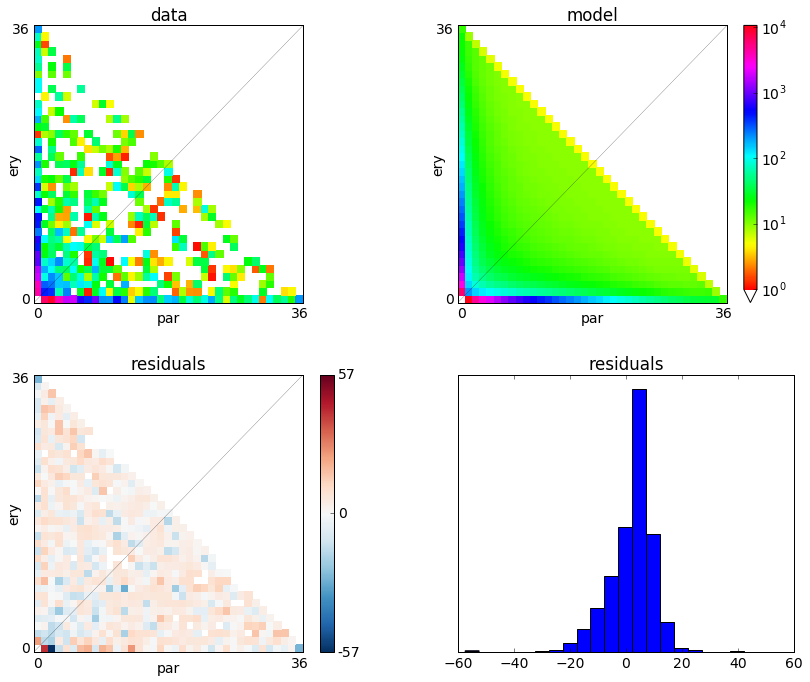

In [58]:
import pylab

%matplotlib inline

pylab.rcParams['figure.figsize'] = [12, 10]
pylab.rcParams['font.size'] = 14

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d, vmin=1)

The best-fit SC model spectrum looks very similar to the best-fit IM model (see previous section).

In [31]:
mu = 3e-9
L = sfs2d.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population Nref of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population Nref of ery and par (in number of diploid individuals) implied by this theta is: 468,535.


The best-fit parameters of this model say the following:

In [32]:
print "After the split of the ancestral population {0:,} generations ago, the daughter populations increased in size (instantaneously).".format(int((popt[2]+popt[3])*2*N_ref)),
print "ERY increased to about the same size as the ancestral population (Nref), while PAR increased to {0:.2f} times of Nref.".format(popt[1]),
print "After the split ERY and PAR diverged in isolation for {0:,} generations.".format(int(popt[2]*2*N_ref)),
print "The two populations came into secondary contact {0:,} generations ago.".format(int(popt[3]*2*N_ref)),
print "ERY and PAR stayed in continuous secondary contact until the present and",
print "during that time exchanged one individual from par to ery every {0:.1f} generations".format(1.0/(popt[4]/2*popt[0])),
print "and one individual from ery into par every {0:.1f} generations.".format(1.0/(popt[4]/2*popt[1]))

After the split of the ancestral population 862,764 generations ago, the daughter populations increased in size (instantaneously). ERY increased to about the same size as the ancestral population (Nref), while PAR increased to 1.77 times of Nref. After the split ERY and PAR diverged in isolation for 61,906 generations. The two populations came into secondary contact 800,858 generations ago. ERY and PAR stayed in continuous secondary contact until the present and during that time exchanged one individual from par to ery every 8.0 generations and one individual from ery into par every 4.5 generations.


Parameter combinations that specify a recent secondary contact model, see rows with index 0, 2 and 9 in upper table, have lower likelihood than parameter combinations that are almost identical to an IM model with constant migration.

How does a recent secondary contact (RSC) model spectrum compare with the data?

In [15]:
df.sort_values(by='Tc_opt', ascending=True)

,nu1_0,nu2_0,Ti_0,Tc_0,m_0,nu1_opt,nu2_opt,Ti_opt,Tc_opt,m_opt,-logL
6,0.268733,0.753785,0.812007,0.023443,1.451094,0.678586,1.296590,0.350150,0.004832,1.924542,19711.069713
9,1.839585,0.749805,1.201031,0.075388,1.137171,0.713783,1.378343,0.374022,0.005218,1.922404,19700.609637
2,1.174580,0.709201,1.369166,0.033279,0.931187,0.624726,1.206711,0.352286,0.071660,0.586254,19359.723909
1,1.006920,2.471800,0.560705,1.489177,0.540249,1.007125,1.785494,0.144681,0.789880,0.249414,18574.820474
0,1.236540,2.847184,0.230733,3.068632,0.849626,0.995633,1.767191,0.089521,0.836080,0.251181,18574.175975
5,0.800833,1.775923,0.481231,0.034021,0.318631,0.993736,1.766119,0.066064,0.854641,0.250961,18574.115189
7,1.736578,0.723766,1.129848,0.030990,0.262542,1.293516,2.273727,0.592114,0.925393,0.228020,18685.067468
3,4.600362,4.057741,0.163307,1.080377,0.070965,1.128504,1.983990,0.054273,1.143632,0.239594,18596.261482
8,0.776660,1.097054,1.000994,0.097170,0.263323,1.994819,3.457283,0.997695,2.225043,0.156405,18756.367519
4,0.409697,0.454478,0.814574,0.040403,1.043188,0.344442,0.572411,0.710683,4.998493,1.070725,24081.306885


In [16]:
# extract parameter combination that specifies a secondary contact model

p_sec_contact = np.array(df.sort_values(by='Tc_opt', ascending=True).iloc[0,5:10])
p_sec_contact

array([ 0.67858642,  1.29659005,  0.35015044,  0.00483189,  1.92454244])

This RSC parameter combination says the following:

In [88]:
print "After the split of the ancestral population {0:,} generations ago, the daughter populations increased in size (instantaneously).".format(int((p_sec_contact[2]+p_sec_contact[3])*2*N_ref)),
print "ERY decreased to about {0:.2f} the size of the ancestral population (Nref), while PAR increased to {1:.2f} times of Nref.".format(p_sec_contact[0],p_sec_contact[1]),
print "After the split ERY and PAR diverged in isolation for {0:,} generations.".format(int(p_sec_contact[2]*2*N_ref)),
print "The two populations came into secondary contact {0:,} generations ago.".format(int(p_sec_contact[3]*2*N_ref)),
print "ERY and PAR stayed in continuous secondary contact until present and",
print "during that time contained a proportion {0:.2e} new immigrant alleles each generations.".format(p_sec_contact[4]/2/N_ref)

After the split of the ancestral population 332,643 generations ago, the daughter populations increased in size (instantaneously). ERY decreased to about 0.68 the size of the ancestral population (Nref), while PAR increased to 1.30 times of Nref. After the split ERY and PAR diverged in isolation for 328,115 generations. The two populations came into secondary contact 4,527 generations ago. ERY and PAR stayed in continuous secondary contact until present and during that time contained a proportion 2.05e-06 new immigrant alleles each generations.


In [17]:
# get the optimally scaled secondary contact model spectrum

SC_model_spectrum = dadi.Inference.optimally_scaled_sfs(func_ex(p_sec_contact, ns, pts_l), sfs2d)

In [18]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [12, 10]
pylab.rcParams['font.size'] = 14

In [98]:
%psource dadi.Plotting.plot_2d_comp_Poisson

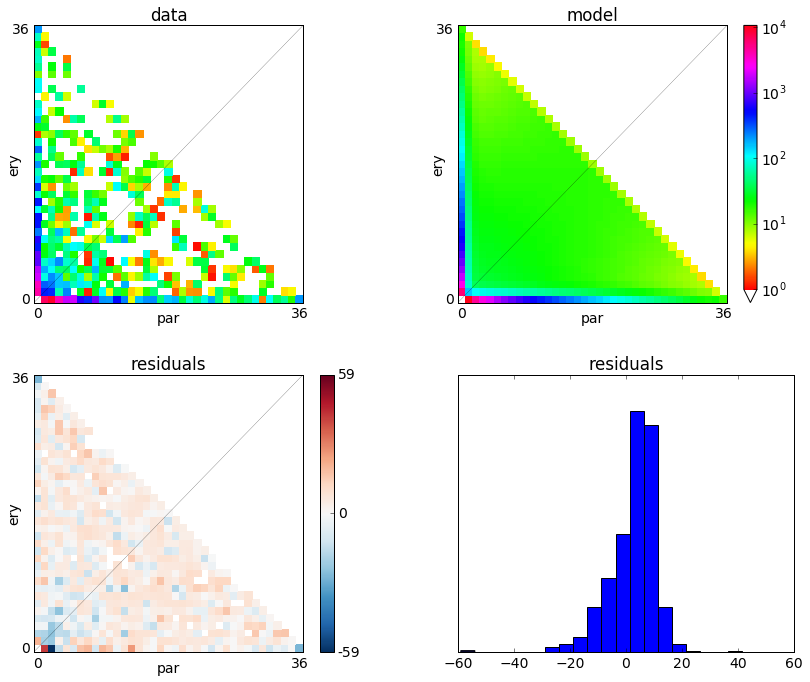

In [23]:
# compare SC model with data

dadi.Plotting.plot_2d_comp_multinom(model=SC_model_spectrum, data=sfs2d, vmin=1)

The recent secondary contact model (RSC) predicts mostly very low frequency introgressed polymorphisms (MAF class 1), but shows a deficit (with respect to the data) of low frequency variants further along the diagonal.

## Compare best fit IM with RSC model spectrum

First, I need to get the best fit IM model spectrum again:

In [19]:
import dill, glob

ar_split_mig_2 = []

for filename in glob.glob("OUT_2D_models/split_mig*dill"):
    ar_split_mig_2.append(dill.load(open(filename)))

In [20]:
success = [flatten(out)[:9] for out in ar_split_mig_2 if out[1][4] == 0]

df_IM = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm_opt', '-logL'])

In [21]:
# get optimal parameter combination for IM model

IM_popt = np.array(df_IM.sort_values(by='-logL', ascending=True).iloc[0, 4:8])
IM_popt

array([ 0.99418511,  1.76612674,  0.92263183,  0.25068798])

In [22]:
# get IM model function (built-in)

IM = dadi.Demographics2D.split_mig

IM_func_ex = dadi.Numerics.make_extrap_log_func(IM)

The best fit IM model spectrum can be extracted with the following code:

In [23]:
IM_model_spectrum = dadi.Inference.optimally_scaled_sfs(IM_func_ex(IM_popt, ns, pts_l).fold(), sfs2d)

In [4]:
%psource dadi.Plotting.plot_2d_comp_multinom

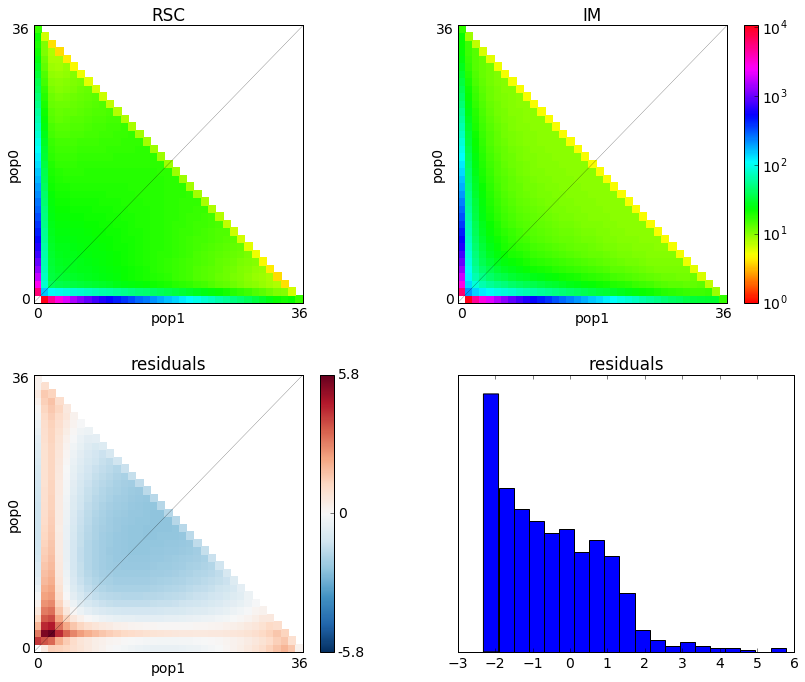

In [24]:
# I have edited the functions `dadi.Plotting.plot_2d_comp_multinom` and `dadi.Plotting.plot_2d_comp_Poisson`
# in `Plotting.py` in the dadi repo to add the argument `title`
dadi.Plotting.plot_2d_comp_multinom(model=IM_model_spectrum, data=SC_model_spectrum.fold(), vmin=1, title=['RSC', 'IM'])

Compared to the IM model, the RSC model predicts many fewer low frequency shared polymorphisms as well as highly diverged polymorphisms (red in the residual plot). On the other hand, recent secondary contact predicts more high frequency shared polymorphisms than isolation with continuous migration (blue in the residual plot).

In [25]:
ll_s = dadi.Inference.ll_multinom(IM_model_spectrum, sfs2d)
ll_s

-18574.1199154733

In [26]:
ll_c = dadi.Inference.ll_multinom(SC_model_spectrum.fold(), sfs2d)
ll_c

-19711.069713468194

The simpler IM model has higher likelihood.

In [27]:
D = 2*(ll_c - ll_s)
D

-2273.8995959897875

In [28]:
# calculate p-value for Chi-square dist. with 1 degree of freedom
p = dadi.Godambe.sum_chi2_ppf(D, weights=(0.5, 0.5))
p

1.0

This is like testing whether $T_i$ is significantly different from 0 (it is 0 in the IM model).

It looks like the simpler IM model is _significantly_ better than the more complex RSC model, but I don't know how to test that. That is I would like to know how confident I can be that the true $T_i$ == 0. In a Bayesian framework I could check whether the 95% CI of the posterior distribution for $T_i$ falls into a (arbitrarily sized) region of practical equivalence (ROPE) with 0. An ABC analysis might be necessary to answer this question statistically. I think what can be said with very high confidence is that $T_i$ cannot be as large as $0.9 \times 2N_{ref}$ as in this parameterisation as this lowers the probability of the data by 1,136 log-likelihood units compared to a $T_i$ of 0.

In [33]:
0.92263183 * 2*N_ref

864570.6174471986

In [34]:
ll_s - ll_c

1136.9497979948937

I doubt that it could it be as simple as:

In [73]:
dadi.Godambe.sum_chi2_ppf(2*(ll_s - ll_c))

0.0

# different migration rates for each direction

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy as np

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [3]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [4]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [41]:
%psource dadi.Demographics2D.split_mig

Define an IM model that allows for unequal migration rates between the two populations.

In [56]:
def split_asym_mig(params, ns, pts):
    """
    params = (nu1,nu2,T,m1,m2)
    ns = (n1,n2)

    Split into two populations of specifed size, with potentially asymmetric migration.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    T: Time in the past of split (in units of 2*Na generations) 
    m1: Migration rate from ery into par (in units of 2*Na ind per generation)
    m2: Migration rate from par into ery (in units of 2*Na ind per generation)
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,T,m1,m2 = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    
    # split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) 
    
    # divergence with potentially asymmetric migration
    phi = dadi.Integration.two_pops(phi, xx, T, nu1, nu2, m12=m2, m21=m1)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [43]:
cl[:].push(dict(split_asym_mig=split_asym_mig))

<AsyncResult: _push>

In [44]:
%%px --local

func = split_asym_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [16]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig" # set file name stub for opt. result files

In [61]:
dadi.Inference.optimize_log_fmin?

In [17]:
from utility_functions import *

---

BEGIN ignore

Ignore this section. Unsuccessfully trying to use `run_dadi` defined in `utility_functions` module.

From the Python Tutorial:

> The global namespace for a module is created when the module definition is read in

and

>  The statements executed by the top-level invocation of the interpreter, either read from a script file or interactively, are considered part of a module called \_\_main\_\_, so they have their own global namespace.

So, my module `utility_functions` has its own global namespace, different from the global namespace of this IPython session. I have there added the line `from __main__ import *` before the definition of the function `run_dadi` in the module `utility_functions`, so that it can see the global namespace if this IPython session.

In [11]:
# perturb these parameter values
# nu1, nu2, T, m1, m2
p0 = [1.0, 1.766, 0.922, 0.25, 0.25] 

# run one optimisation locally
run_dadi(p0)

(array([ 1.93002308,  2.12950808,  0.36138972,  0.49458589,  0.24351897]),
 (array([ 1.16826555,  2.89820108,  1.96146766,  0.06817234,  0.40888606]),
  18126.331780591565,
  171,
  321,
  0))

It works locally.

In [48]:
from itertools import repeat

In [49]:
lbview = cl.load_balanced_view()

In [50]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m1, m2
upper_bound = [1e4, 1e4, 4, 10, 10] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0]

In [21]:
# using optimal parameters from simple divergence with migration model (split_mig)
p0 = [1.0, 1.766, 0.922, 0.25, 0.25] 

ar_split_asym_mig_1 = lbview.map(run_dadi, repeat(p0, 1), block=False, order=True)

In [22]:
ar_split_asym_mig_1.get()

CompositeError: one or more exceptions from call to method: run_dadi
[15:apply]: NameError: global name 'perturb' is not defined

END ignore.

---

In [60]:
dadi.Misc.perturb_params?

In [53]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m1, m2
upper_bound = [1e4, 1e4, 4, 10, 10] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0]

In [54]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [58]:
from itertools import repeat

In [56]:
lbview = cl.load_balanced_view()

In [57]:
# using optimal parameters from simple divergence with migration model (split_mig)
p0 = [1.0, 1.766, 0.922, 0.25, 0.25] 

In [15]:
#ar_split_asym_mig_1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [28]:
get_flag_count(ar_split_asym_mig_1, NM=True)

success 3
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 7
unknown flag 0


In [10]:
import dill
from glob import glob

In [11]:
ar_split_asym_mig = []

for filename in glob("OUT_2D_models/split_asym_mig*dill"):
    ar_split_asym_mig.append(dill.load(open(filename)))

In [12]:
import pandas as pd

In [15]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_split_asym_mig if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
16,0.782220,1.448548,4.639001,0.072158,0.638342,0.920911,2.238617,1.244681,0.084147,0.494918,18104.966267
0,0.661003,7.163811,1.265469,0.257890,0.190122,0.920526,2.236116,1.241691,0.084361,0.494500,18104.971893
2,0.303698,1.230424,0.319167,0.222183,0.228972,0.922813,2.243404,1.254244,0.083942,0.494334,18104.983699
1,0.287213,1.386083,0.493232,0.096763,0.103789,0.915567,2.223840,1.228988,0.084270,0.497170,18105.001298
10,0.234347,0.568305,0.310253,0.112591,0.538129,0.912096,2.209951,1.210935,0.084060,0.497975,18105.141289
14,0.445903,1.955658,2.155467,0.025188,0.607712,0.928113,2.253559,1.279568,0.084935,0.493929,18105.232355
12,0.840609,1.431975,0.454631,0.032701,0.460575,0.933747,2.248026,1.278518,0.086974,0.490424,18105.547423
19,0.318476,1.235161,0.915553,0.202189,0.451816,0.889937,2.161759,1.149623,0.084294,0.506266,18106.119019
11,0.690318,5.005598,4.836252,0.090996,0.826606,0.863008,2.164950,1.144191,0.081105,0.540134,18111.340526
13,0.938970,5.369017,0.555250,0.035365,0.192065,0.802773,2.001577,0.992511,0.080623,0.556180,18121.001018


These 4 optimisations consistently indicate a much smaller gene flow from _erythropus_ into _parallelus_ than in the other direction. This seems plausible when considering the observed expansion of the range of parallelus towards the south of the Pyrenees. Shapes of neutral clines across the hybrid zone should also be less steep on the _erythropus_ side than on the _parallelus_ side.

In [35]:
%%px --local

maxiter = 500

In [36]:
cl[1]['fold']

2

In [37]:
upper_bound

[10000.0, 10000.0, 4, 10, 10]

I will need to increase the upper bound on the divergence time $T$. Otherwise, perturbation can result in starting values above the upper bound.

In [38]:
%%px --local

upper_bound = [10000.0, 10000.0, 6, 10, 10]

In [39]:
# using previous optimal parameters as starting values to perturb
p0 = [0.915567, 2.223840, 1.228988, 0.084270, 0.497170] 

#ar_split_asym_mig_2 = lbview.map(run_dadi, repeat(p0, 20), block=False, order=True)

In [15]:
ar_split_asym_mig = []

for filename in glob("OUT_2D_models/split_asym_mig*dill"):
    ar_split_asym_mig.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_split_asym_mig if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
16,0.782220,1.448548,4.639001,0.072158,0.638342,0.920911,2.238617,1.244681,0.084147,0.494918,18104.966267
0,0.661003,7.163811,1.265469,0.257890,0.190122,0.920526,2.236116,1.241691,0.084361,0.494500,18104.971893
2,0.303698,1.230424,0.319167,0.222183,0.228972,0.922813,2.243404,1.254244,0.083942,0.494334,18104.983699
1,0.287213,1.386083,0.493232,0.096763,0.103789,0.915567,2.223840,1.228988,0.084270,0.497170,18105.001298
10,0.234347,0.568305,0.310253,0.112591,0.538129,0.912096,2.209951,1.210935,0.084060,0.497975,18105.141289
14,0.445903,1.955658,2.155467,0.025188,0.607712,0.928113,2.253559,1.279568,0.084935,0.493929,18105.232355
12,0.840609,1.431975,0.454631,0.032701,0.460575,0.933747,2.248026,1.278518,0.086974,0.490424,18105.547423
19,0.318476,1.235161,0.915553,0.202189,0.451816,0.889937,2.161759,1.149623,0.084294,0.506266,18106.119019
11,0.690318,5.005598,4.836252,0.090996,0.826606,0.863008,2.164950,1.144191,0.081105,0.540134,18111.340526
13,0.938970,5.369017,0.555250,0.035365,0.192065,0.802773,2.001577,0.992511,0.080623,0.556180,18121.001018


There is good convergence of parameter estimates.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [35]:
from glob import glob
import dill

In [37]:
ar_split_asym_mig = []

for filename in glob("OUT_2D_models/split_asym_mig_[1234567890]*dill"):
    ar_split_asym_mig.append(dill.load(open(filename)))
    
l = 2*5+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
1,0.690910,1.962277,0.655486,0.716114,0.081910,0.929836,2.267261,1.289605,0.085435,0.493187,18105.358461
10,0.474111,0.694113,1.372862,0.274980,0.360411,0.915513,2.217017,1.244177,0.087882,0.492707,18105.676702
2,0.374716,0.762272,0.893552,0.102632,0.794584,0.821036,2.008494,0.953877,0.081085,0.535729,18121.484292
4,0.508079,1.207476,1.435114,0.198507,0.616905,0.822370,1.938384,0.927379,0.087170,0.520851,18125.149235
3,2.769222,0.647108,1.353683,0.115349,0.255028,1.091256,2.748012,1.889591,0.068154,0.450564,18125.300712
6,2.762117,1.263134,0.827294,0.321558,0.722256,0.827753,1.938023,0.910884,0.094737,0.499529,18129.919009
0,0.851793,4.949280,0.377467,0.114910,0.249700,0.743511,1.889542,0.880640,0.075930,0.593904,18148.593880
7,0.479148,2.697403,1.308368,0.063333,0.771626,0.726636,1.853824,0.862483,0.055201,0.679454,18195.974398
5,3.615531,1.620456,0.242806,0.071169,0.388806,0.899524,2.471708,1.095278,0.018243,0.521348,18305.658175
8,2.236108,0.586673,0.475731,0.151910,0.125131,0.723413,1.961768,0.792235,0.000248,0.658915,18339.654185


No better parameter combinations than seen before can be found here.

## plain English

In [16]:
import numpy as np

In [17]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 5:10])
popt

array([ 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818])

In [18]:
func = split_asym_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [22]:
# calculate best-fit model spectrum

model_spectrum = func_ex(popt, ns, pts_l)

model_spectrum_asym_mig_scaled = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d)

In [23]:
theta = dadi.Inference.optimal_sfs_scaling(model_spectrum, sfs2d)

In [24]:
print "The optimal value of theta for the ancestral population is {0:4d}.".format(int(theta))

The optimal value of theta for the ancestral population is 5572.


In [25]:
mu = 3e-9
L = sfs2d.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 410,678.


In [29]:
print "The ancestral population split apart {0:,} generations ago.".format(int(popt[2]*2*N_ref)),
print "Immediately after the split the ERY population changed to a size of {0:.2f} times Nref and the PAR population to {1:.2f} times Nref.".format(popt[0], popt[1]),
print "Since the split of the ancestral population, PAR received 1 individual from ERY every {0:.2f} generations,".format(1.0/(popt[3]/2*popt[1])),
print "while ERY received 1 PAR individual every {0:.2f} generations.".format(1.0/(popt[4]/2*popt[0])),
print "Put another way: The par population contained a constant proportion of {0:.2e} of new immigrant alleles each generation".format(popt[3]/2/N_ref),
print "and the ery population contained a constant proportion of {0:.2e} of new immigrant alleles each generation.".format(popt[4]/2/N_ref)

The ancestral population split apart 1,022,329 generations ago. Immediately after the split the ERY population changed to a size of 0.92 times Nref and the PAR population to 2.24 times Nref. Since the split of the ancestral population, PAR received 1 individual from ERY every 10.62 generations, while ERY received 1 PAR individual every 4.39 generations. Put another way: The par population contained a constant proportion of 1.02e-07 of new immigrant alleles each generation and the ery population contained a constant proportion of 6.03e-07 of new immigrant alleles each generation.


This model therefore indicates a much stronger introgression from _parallelus_ into _erythropus_ than in the opposite direction. Is the asymmetrical gene flow significant?

## LRT

In [30]:
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d)
ll_c

-18104.966266885222

In [31]:
# get maximum log likelihood of best fit parameter combination for the model
# with symmetrical migration rates

func = dadi.Demographics2D.split_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

# best-fit paramter combination for the split_mig model (see section 2 above)
popt_split_mig = [0.994185, 1.766127, 0.922632, 0.250688]

model_spectrum_sym_mig = func_ex(popt_split_mig, ns, pts_l)

model_spectrum_sym_mig_scaled = dadi.Inference.optimally_scaled_sfs(model_spectrum_sym_mig, sfs2d)

ll_s = dadi.Inference.ll_multinom(model_spectrum_sym_mig, sfs2d)
ll_s

-18574.11991248127

In [32]:
D = 2*(ll_c - ll_s)
D

938.30729119209718

In [77]:
# calculate p-value for Chi-square dist. with 1 degree of freedom
p = dadi.Godambe.sum_chi2_ppf(D)
p

0.0

It looks as though allowing for asymmetrical gene flow significantly improves the fit to the data. Linkage is unlikely to push the p-value above a significance value of 1e-2, for instance.

## Is the migration rate from ery into par (_m1_) statistically significant?

In [63]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig_nom1" # set file name stub for opt. result files
# fix m1 to zero, allow all other parameters to be optimised:
fixed_params = [None, None, None, 0.0, None] # specify None to optimise all params

In [70]:
dadi.Inference.optimize_log_fmin?

In [62]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                                 fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [69]:
# using optimal parameters as starting values to perturb
# m1 (0.084) will be ignored
p0 = popt 
p0

array([ 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818])

In [66]:
#ar_split_asym_mig_nom1 = lbview.map(run_dadi, repeat(p0, 10), block=False, order=True)

In [67]:
ar_split_asym_mig_nom1 = []

for filename in glob("OUT_2D_models/split_asym_mig_nom1*dill"):
    ar_split_asym_mig_nom1.append(dill.load(open(filename)))

In [71]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_split_asym_mig_nom1 if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,T_0,m1_0,m2_0,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
3,0.604286,1.689639,1.086538,0.048727,0.585935,0.720082,1.962785,0.791503,0.0,0.664581,18340.935861
6,1.197798,1.060943,0.387950,0.070337,0.177612,0.718508,1.960294,0.788789,0.0,0.664332,18340.951096
4,0.588394,3.336045,2.176182,0.035238,0.433038,0.721147,1.961776,0.791353,0.0,0.664706,18340.964537
2,0.400697,4.483709,0.486604,0.282474,0.612249,0.721305,1.961497,0.790718,0.0,0.663976,18340.965653
1,0.250388,0.933745,0.381047,0.123940,1.702059,0.717236,1.953896,0.786673,0.0,0.667389,18340.972028
7,1.163790,2.959924,0.753380,0.124571,0.155288,0.719228,1.967604,0.794908,0.0,0.669281,18341.008850
5,0.331430,2.693409,0.905852,0.078054,0.398861,0.743397,2.058666,0.871767,0.0,0.663042,18345.753837
0,0.258239,2.546149,2.410812,0.024995,0.808097,0.658928,1.875663,0.777684,0.0,0.783119,18374.981997


This looks like convergence.

In [72]:
# extract optimal parameter values from data frame
popt_nom1 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 5:10])
popt_nom1

array([ 0.72008153,  1.96278543,  0.79150302,  0.        ,  0.66458054])

In [76]:
# calculate best-fit model spectrum
model_spectrum_nom1 = func_ex(popt_nom1, ns, pts_l)

model_spectrum_nom1_scaled = dadi.Inference.optimally_scaled_sfs(model_spectrum_nom1, sfs2d)

In [78]:
# get log likelihood of best-fit spectrum of IM model without ery->par migration
ll_s = dadi.Inference.ll_multinom(model_spectrum_nom1, sfs2d)
ll_s

-18340.935861366052

In [77]:
# get log likelihood for model that also optimised m1 (from above)
ll_c = dadi.Inference.ll_multinom(model_spectrum, sfs2d)
ll_c

-18104.966266885222

In [79]:
D = 2*(ll_c - ll_s)
D

471.93918896165997

In [81]:
# calculate p-value for Chi-square dist.
# the weights specify a weighted sum of a chi^2 dist.'s with 1 d.o.f and a chi^2 with 2 d.o.f
# 
p = dadi.Godambe.sum_chi2_ppf(D, weights=(0.5, 0.5))
p

0.0

The gene flow from ery into par is highly significant. It is unlikely that this result can be compromised by linkage between the SNP's.

## plot

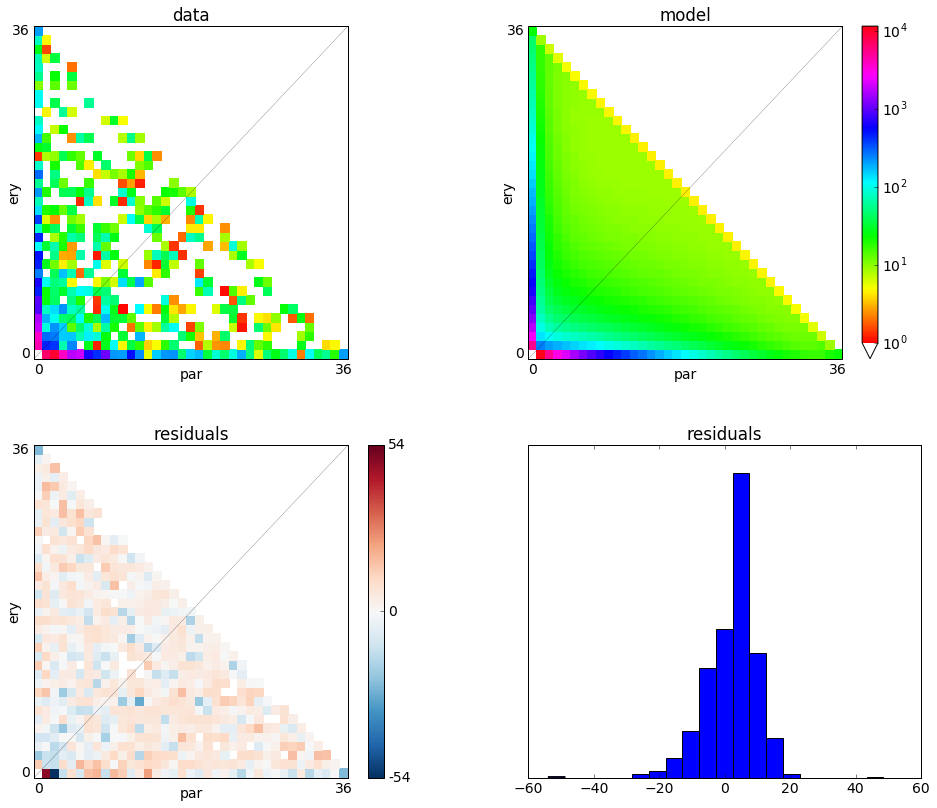

In [33]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [14, 12]
pylab.rcParams['font.size'] = 14

dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d, vmin=1)

Plot residuals between IM models with symmetrical and asymmetrical migration.

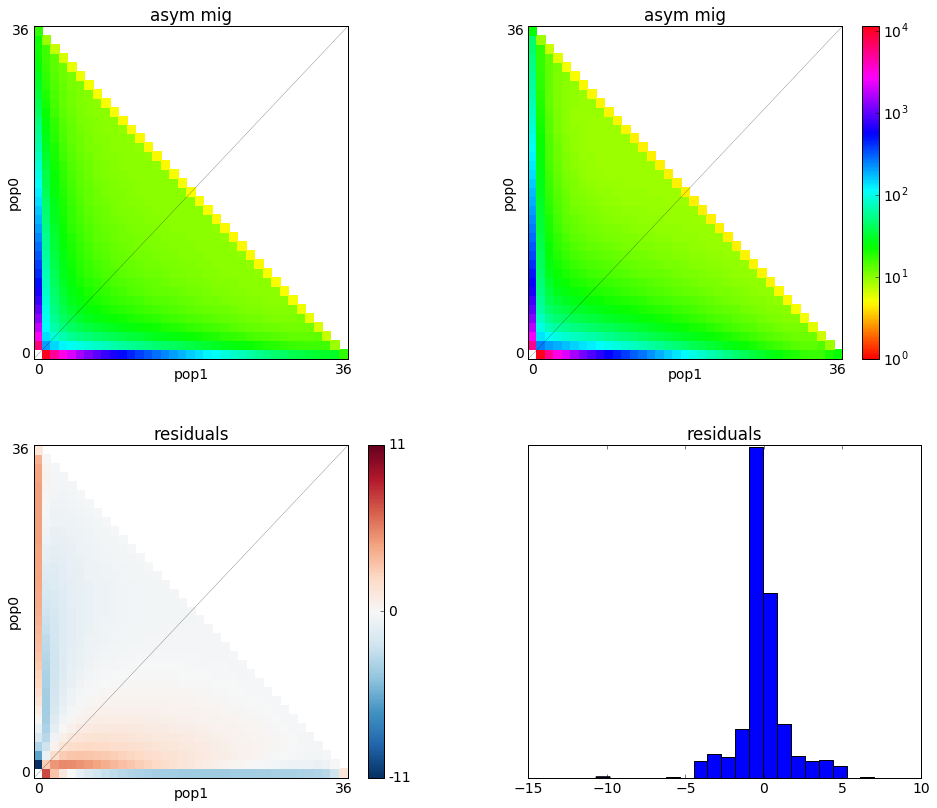

In [36]:
dadi.Plotting.plot_2d_comp_multinom(model=model_spectrum_asym_mig_scaled.fold(), \
                                    data=model_spectrum_sym_mig_scaled.fold(), vmin=1,\
                                   title=['sym mig', 'asym mig'])

The model spectrum for asymmetric gene flow has an excess (brown) of low to medium MAF SNP's in PAR that occur at low frequency in ERY.

In [40]:
popt_split_mig = popt_split_mig + [popt_split_mig[-1]]
popt_split_mig

[0.994185, 1.766127, 0.922632, 0.250688, 0.250688]

In [44]:
pd.DataFrame(data=np.array([popt_split_mig, popt]), index=['sym_mig', 'asym_mig'], columns=['nu1', 'nu2', 'T', 'm1', 'm2'])

,nu1,nu2,T,m1,m2
sym_mig,0.994185,1.766127,0.922632,0.250688,0.250688
asym_mig,0.920911,2.238617,1.244681,0.084147,0.494918


The excess of SNP's in MAF categroy 1 that did not introgress from PAR into ERY could be due to the greater population size increase inferred for PAR in the asymmetric gene flow model, although this model also inferred a greater time since the population size increase which should lead to greater equilibration of the initial rise in low frequency variants.

# recent bottleneck

At the end of the last Ice Age, about 10 Ky ago, both ERY and PAR expanded from refugial areas across Iberia and across northern, central and western Europe, respectively. This expansion likely happened by long-distance migration, where only very few individuals colonised a new habitat. This should lead to a series of founder events that successively reduced genetic diversity the further away from the refugium.

In [35]:
from glob import glob
import dill
from utility_functions import *
import pandas as pd
# turn on floating point division by default, old behaviour via '//'
from __future__ import division

In [6]:
lbview = cl.load_balanced_view()
from itertools import repeat

In [7]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [12, 10]
pylab.rcParams['font.size'] = 14

In [36]:
def split_asym_mig_2epoch(params, ns, pts):
    """
    params = (nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2)
    ns = (n1,n2)

    Split into two populations of specified size, with potentially asymmetric migration.
    The split coincides with a stepwise size change in the daughter populations. Then,
    have a second stepwise size change at some point in time after the split. This is
    enforced to happen at the same time for both populations. Migration is assumed to
    be the same during both epochs.

    nu1_1: pop size ratio of pop 1 after split (with respect to Na)
    nu2_1: pop size ratio of pop 2 after split (with respect to Na)
    T1: Time from split to second size change (in units of 2*Na generations)
    nu1_2: pop size ratio of pop 1 after second size change (with respect to Na)
    nu2_2: pop size ratio of pop 2 after second size change (with respect to Na)
    T2: time in past of second size change (in units of 2*Na generations)
    m1: Migration rate from ery into par (in units of 2*Na ind per generation)
    m2: Migration rate from par into ery (in units of 2*Na ind per generation)
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2 = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    
    # split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) 
    
    # divergence with potentially asymmetric migration for time T1
    phi = dadi.Integration.two_pops(phi, xx, T1, nu1_1, nu2_1, m12=m2, m21=m1)
    
    # divergence with potentially asymmetric migration and different pop size for time T2
    phi = dadi.Integration.two_pops(phi, xx, T2, nu1_2, nu2_2, m12=m2, m21=m1)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [37]:
cl[:].push(dict(split_asym_mig_2epoch=split_asym_mig_2epoch))

<AsyncResult: _push>

In [38]:
%%px --local

func = split_asym_mig_2epoch

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [39]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig_2epoch" # set file name stub for opt. result files
fixed_params = None

In [12]:
%%px --local

# set lower and upper bounds to nu1, nu2, T, m1, m2
upper_bound = [1e4, 1e4, 6, 1e4, 1e4, 6, 10, 10]
lower_bound = [1e-4, 1e-4, 0, 1e-4, 1e-4, 0, 0, 0]

In [40]:
p0 = [1.0, 3.0, 2.0, 1.5, 3.8, 0.343805, 0.076152, 0.347306]

In [27]:
#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [29]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
7,0.898918,3.653682,2.280917,0.852159,5.679510,0.144611,0.163023,0.229363,0.947082,3.831574,1.201702,0.719823,0.253228,1.137441e-02,0.008005,0.582316,17079.658485
6,0.426130,11.130330,0.873932,1.440192,2.810714,1.026079,0.068275,0.349763,0.437815,8.855030,0.799110,1.108959,2.737695,1.033802e+00,0.055712,0.468002,18212.928414
9,3.552815,1.004041,1.383169,0.931193,3.560051,0.523227,0.149104,0.130807,8.638799,1.006226,1.122534,0.919121,2.720225,9.229929e-01,0.099630,0.538983,18331.162782
2,0.417261,1.167711,5.940000,5.180033,3.906087,0.386400,0.260601,0.107789,0.356113,1.277333,1.290728,1.090841,3.445879,1.521465e+00,0.025474,0.521200,18400.284325
0,3.783757,1.397394,1.012039,0.662241,1.162849,0.087606,0.150898,0.741257,0.792282,1.452968,0.999551,0.594351,1.413203,6.015430e-02,0.186769,0.628973,18425.087805
5,1.295752,1.583563,2.841882,0.491575,2.822075,0.819369,0.063739,0.342622,1.560778,1.820231,2.176539,1.039025,3.147006,7.588005e-01,0.081431,0.494638,18460.350865
3,0.429057,1.531906,2.800356,5.550939,2.833422,0.507195,0.213008,0.090128,0.533155,2.572582,1.617799,1.140894,3.286325,6.372817e-01,0.059433,0.500271,18473.722381
8,0.557646,11.549954,0.788876,1.724977,11.764670,1.049013,0.072282,0.854824,0.365119,43.546554,0.828317,0.823591,2.686956,1.015297e+00,0.001295,0.764306,18753.912572
4,0.902598,3.620154,0.792691,0.929034,4.181031,0.086890,0.218301,0.953254,0.822321,2.533391,1.870343,1.016569,0.737391,1.222165e-07,0.020176,0.909164,18998.965344
1,3.716088,1.067851,2.302973,3.756988,3.808611,0.650045,0.084223,0.332164,6.516835,1.104266,2.524346,1.155734,3.018727,6.200311e-01,0.176459,0.261394,19284.083228


In [30]:
popt = df.sort_values(by='-logL', ascending=True).iloc[0,8:16]
popt

nu1_opt      0.947082
nu2_opt      3.831574
T1_opt       1.201702
nu1_2_opt    0.719823
nu2_2_opt    0.253228
T2_opt       0.011374
m1_opt       0.008005
m2_opt       0.582316
Name: 7, dtype: float64

In [36]:
p0 = np.array(popt)

#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [15]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
23,0.898918,3.653682,2.280917,0.852159,5.679510,0.144611,0.163023,0.229363,0.947082,3.831574,1.201702,0.719823,0.253228,0.011374,8.005247e-03,0.582316,17079.658485
5,0.420112,10.591144,2.671529,0.530414,0.124964,0.022842,0.002137,0.459722,1.107169,4.419118,2.338366,0.349534,0.141844,0.005060,3.218103e-03,0.500631,17209.897603
14,2.38668,11.067915,0.628179,1.373336,0.390471,0.036832,0.004121,0.877207,0.613854,3.301758,0.630973,0.743053,0.185155,0.009038,2.899400e-05,0.771052,17251.302782
26,0.334635,9.904406,1.370532,1.317616,0.357278,0.003738,0.009932,0.477835,0.912044,4.698576,1.416278,1.381801,0.204434,0.009370,1.890686e-03,0.557015,17299.923700
7,0.298034,3.504703,0.558703,0.248371,0.672021,0.010772,0.003784,0.959529,0.597001,3.645979,0.600901,0.546200,0.560962,0.035583,2.972754e-04,0.948664,17495.828174
27,3.56809,9.896407,3.522931,1.258268,0.791879,0.008024,0.002567,0.387224,1.979935,8.339897,4.859447,1.360735,0.793592,0.032059,9.168825e-04,0.312377,17502.706013
12,2.79017,3.421109,0.876374,1.064335,0.444588,0.003049,0.005017,1.861713,0.546773,3.156319,0.809249,1.114021,0.352992,0.013018,9.505209e-05,1.169710,18016.811842
9,0.995434,1.632234,0.308876,1.393467,0.192583,0.024691,0.005261,1.441551,0.995405,3.743586,1.785805,2.590547,0.731451,0.021359,8.119028e-07,0.578577,18037.589174
11,0.488288,7.672506,3.603842,1.225374,0.269718,0.003882,0.017218,0.291497,0.900536,8.540286,3.621163,1.392801,0.192291,0.013124,2.966765e-03,0.713634,18064.529099
18,0.365743,1.233753,0.908903,2.327532,0.071710,0.010509,0.025416,0.409673,0.815066,1.834017,0.873402,0.594443,1.501876,0.000030,1.007240e-01,0.518227,18144.556345


In [25]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,8:16])
popt

array([0.94708150816833536, 3.8315744841549426, 1.2017020166706207,
       0.71982281273823534, 0.25322772844223501, 0.011374413880093007,
       0.0080052470233440004, 0.5823162256176253], dtype=object)

In [24]:
p0 = [0.94708150816833536, 3.8315744841549426, 1.2017020166706207,0.71982281273823534, 0.25322772844223501, 0.011374413880093007,0.0080052470233440004, 0.5823162256176253]

#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [26]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
35,0.273987,4.652004,1.857477,0.209478,0.292941,0.003369,0.008608,0.324512,1.714854,4.916260,2.409658,0.134558,0.160657,0.004939,0.027701,0.364619,16933.617707
17,0.329423,4.586391,1.937792,0.358574,0.272985,0.015062,0.003967,0.265708,1.370876,5.558320,2.333318,0.272652,0.169133,0.007429,0.004863,0.455955,17046.826820
31,0.898918,3.653682,2.280917,0.852159,5.679510,0.144611,0.163023,0.229363,0.947082,3.831574,1.201702,0.719823,0.253228,0.011374,0.008005,0.582316,17079.658485
9,0.420112,10.591144,2.671529,0.530414,0.124964,0.022842,0.002137,0.459722,1.107169,4.419118,2.338366,0.349534,0.141844,0.005060,0.003218,0.500631,17209.897603
22,2.38668,11.067915,0.628179,1.373336,0.390471,0.036832,0.004121,0.877207,0.613854,3.301758,0.630973,0.743053,0.185155,0.009038,0.000029,0.771052,17251.302782
34,0.334635,9.904406,1.370532,1.317616,0.357278,0.003738,0.009932,0.477835,0.912044,4.698576,1.416278,1.381801,0.204434,0.009370,0.001891,0.557015,17299.923700
11,0.547123,5.727831,3.965933,1.469151,0.240384,0.004714,0.008788,1.147695,0.517247,4.141955,0.771098,1.633862,0.039186,0.002424,0.009249,1.177685,17385.121573
12,0.298034,3.504703,0.558703,0.248371,0.672021,0.010772,0.003784,0.959529,0.597001,3.645979,0.600901,0.546200,0.560962,0.035583,0.000297,0.948664,17495.828174
37,3.56809,9.896407,3.522931,1.258268,0.791879,0.008024,0.002567,0.387224,1.979935,8.339897,4.859447,1.360735,0.793592,0.032059,0.000917,0.312377,17502.706013
20,1.68243,1.235096,2.032456,0.360877,0.105845,0.007502,0.003049,0.979017,0.578598,1.953621,1.003614,0.125840,0.120642,0.002884,0.001177,0.970431,17694.233568


In [27]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,8:16])
popt

array([1.7148538096681663, 4.9162601290093262, 2.4096584681561115,
       0.13455833748374804, 0.16065741923794288, 0.0049387150509544253,
       0.027701205471474446, 0.36461853899050334], dtype=object)

In [28]:
p0 = [1.7148538096681663, 4.9162601290093262, 2.4096584681561115,0.13455833748374804, 0.16065741923794288, 0.0049387150509544253,0.027701205471474446, 0.36461853899050334]

#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [29]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
20,1.21024,1.859283,1.246142,0.044026,0.280226,0.001255,0.009559,0.630624,1.045642,3.695906,1.221329,0.127229,0.082312,0.003371,0.063492,0.546522,16675.062256
38,0.952198,12.865180,5.092487,0.053520,0.043041,0.001896,0.033163,0.171996,0.932776,4.926058,1.555495,0.033974,0.006842,0.000329,0.022105,0.634907,16823.602617
37,2.67701,3.844282,5.940000,0.071274,0.206304,0.016864,0.037265,0.286890,1.910635,4.814980,3.433630,0.135244,0.164419,0.004082,0.079042,0.286221,16873.770488
45,0.273987,4.652004,1.857477,0.209478,0.292941,0.003369,0.008608,0.324512,1.714854,4.916260,2.409658,0.134558,0.160657,0.004939,0.027701,0.364619,16933.617707
21,0.329423,4.586391,1.937792,0.358574,0.272985,0.015062,0.003967,0.265708,1.370876,5.558320,2.333318,0.272652,0.169133,0.007429,0.004863,0.455955,17046.826820
41,0.898918,3.653682,2.280917,0.852159,5.679510,0.144611,0.163023,0.229363,0.947082,3.831574,1.201702,0.719823,0.253228,0.011374,0.008005,0.582316,17079.658485
10,0.420112,10.591144,2.671529,0.530414,0.124964,0.022842,0.002137,0.459722,1.107169,4.419118,2.338366,0.349534,0.141844,0.005060,0.003218,0.500631,17209.897603
29,2.38668,11.067915,0.628179,1.373336,0.390471,0.036832,0.004121,0.877207,0.613854,3.301758,0.630973,0.743053,0.185155,0.009038,0.000029,0.771052,17251.302782
19,1.53725,2.529480,0.870356,0.145174,0.462106,0.001638,0.014881,0.734821,1.028818,4.052293,0.868129,0.331342,0.473554,0.020509,0.051548,0.481620,17278.876804
44,0.334635,9.904406,1.370532,1.317616,0.357278,0.003738,0.009932,0.477835,0.912044,4.698576,1.416278,1.381801,0.204434,0.009370,0.001891,0.557015,17299.923700


In [30]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,8:16])
popt

array([1.0456418566167558, 3.6959057980884156, 1.2213291569132876,
       0.12722919734283214, 0.082311967206571773, 0.0033710890551920097,
       0.063492045724766522, 0.54652237829166095], dtype=object)

In [31]:
p0 = [1.0456418566167558, 3.6959057980884156, 1.2213291569132876,0.12722919734283214, 0.082311967206571773, 0.0033710890551920097,0.063492045724766522, 0.54652237829166095]

#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [33]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
16,0.90243,3.959105,3.505129,0.098717,0.105577,0.001006,0.155078,0.561180,0.908780,3.534277,1.144074,0.082374,0.033507,0.001425,0.078269,0.562974,16671.396696
24,1.21024,1.859283,1.246142,0.044026,0.280226,0.001255,0.009559,0.630624,1.045642,3.695906,1.221329,0.127229,0.082312,0.003371,0.063492,0.546522,16675.062256
46,0.952198,12.865180,5.092487,0.053520,0.043041,0.001896,0.033163,0.171996,0.932776,4.926058,1.555495,0.033974,0.006842,0.000329,0.022105,0.634907,16823.602617
45,2.67701,3.844282,5.940000,0.071274,0.206304,0.016864,0.037265,0.286890,1.910635,4.814980,3.433630,0.135244,0.164419,0.004082,0.079042,0.286221,16873.770488
28,1.17171,1.929520,2.410158,0.161339,0.027241,0.002363,0.026557,0.178123,1.151455,2.882799,0.985790,0.065198,0.036818,0.001220,0.098290,0.381358,16915.754183
54,0.273987,4.652004,1.857477,0.209478,0.292941,0.003369,0.008608,0.324512,1.714854,4.916260,2.409658,0.134558,0.160657,0.004939,0.027701,0.364619,16933.617707
25,0.329423,4.586391,1.937792,0.358574,0.272985,0.015062,0.003967,0.265708,1.370876,5.558320,2.333318,0.272652,0.169133,0.007429,0.004863,0.455955,17046.826820
49,0.898918,3.653682,2.280917,0.852159,5.679510,0.144611,0.163023,0.229363,0.947082,3.831574,1.201702,0.719823,0.253228,0.011374,0.008005,0.582316,17079.658485
12,0.420112,10.591144,2.671529,0.530414,0.124964,0.022842,0.002137,0.459722,1.107169,4.419118,2.338366,0.349534,0.141844,0.005060,0.003218,0.500631,17209.897603
37,2.38668,11.067915,0.628179,1.373336,0.390471,0.036832,0.004121,0.877207,0.613854,3.301758,0.630973,0.743053,0.185155,0.009038,0.000029,0.771052,17251.302782


In [34]:
%%px --local

pts_l = [50, 60, 70]
dadi_opt_func = dadi.Inference.optimize_log # uses BFGS algorithm
fold = 1 # perturb randomly up to `fold` times 2-fold
maxiter = 100 # run a maximum of 100 iterations

In [35]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,8:16])
popt

array([0.90877952357019698, 3.5342771794685697, 1.1440736311780284,
       0.082373742973961023, 0.033507304302622123, 0.0014247576674479255,
       0.078269443701444424, 0.5629736811087368], dtype=object)

In [36]:
p0 = [0.90877952357019698, 3.5342771794685697, 1.1440736311780284,0.082373742973961023, 0.033507304302622123, 0.0014247576674479255,0.078269443701444424, 0.5629736811087368]

#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [37]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
68,0.881931,1.865893,1.127682,0.061479,0.023577,0.000881,0.052769,0.471943,1.017913,3.697532,1.269578,0.000402,0.000210,0.000009,0.067195,0.549626,16625.966962
24,0.466823,3.472339,1.303130,0.162972,0.041767,0.001838,0.128362,0.867417,1.051572,3.676876,1.341481,0.001260,0.000696,0.000027,0.069978,0.528975,16626.155821
15,1.00542,3.284359,0.599398,0.160978,0.041053,0.001515,0.071776,0.827104,1.055235,3.718574,1.362821,0.000879,0.000482,0.000019,0.068950,0.525681,16626.319938
44,0.502502,5.501741,0.616182,0.093234,0.029584,0.000851,0.123859,0.397414,1.019063,3.663885,1.266102,0.000555,0.000289,0.000012,0.069337,0.546020,16626.457480
16,1.70953,2.571269,2.233426,0.085827,0.054249,0.001121,0.041765,0.460956,1.024110,3.720218,1.298106,0.000511,0.000271,0.000011,0.066764,0.540440,16626.520113
58,1.2727,2.986901,0.937316,0.087190,0.037291,0.002594,0.132506,0.981799,1.002533,3.577045,1.254369,0.001124,0.000613,0.000024,0.060806,0.558193,16627.796720
2,0.692217,1.879285,1.153645,0.126593,0.036675,0.001046,0.105353,0.593608,1.061396,3.634080,1.319702,0.000177,0.000100,0.000004,0.061132,0.527127,16629.772073
19,0.90243,3.959105,3.505129,0.098717,0.105577,0.001006,0.155078,0.561180,0.908780,3.534277,1.144074,0.082374,0.033507,0.001425,0.078269,0.562974,16671.396696
30,1.21024,1.859283,1.246142,0.044026,0.280226,0.001255,0.009559,0.630624,1.045642,3.695906,1.221329,0.127229,0.082312,0.003371,0.063492,0.546522,16675.062256
53,0.952198,12.865180,5.092487,0.053520,0.043041,0.001896,0.033163,0.171996,0.932776,4.926058,1.555495,0.033974,0.006842,0.000329,0.022105,0.634907,16823.602617


In [38]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,8:16])
popt

array([1.0179130901393454, 3.6975318699708484, 1.2695784485894963,
       0.00040204669127636192, 0.00020950770841736489,
       8.6260651610300379e-06, 0.06719544663984639, 0.54962618122149143], dtype=object)

In [14]:
p0 = [1.0179130901393454, 3.6975318699708484, 1.2695784485894963,0.00040204669127636192, 0.00020950770841736489,8.6260651610300379e-06, 0.06719544663984639, 0.54962618122149143]

#ar_split_asym_mig_2epoch = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [44]:
ar_split_asym_mig_2epoch = []

for filename in glob("OUT_2D_models/split_asym_mig_2epoch_[1234567890]*dill"):
    ar_split_asym_mig_2epoch.append(dill.load(open(filename)))
    
l = 2*len(p0)+1

# get parameters from "unsuccessfull" optimisations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_2epoch]

#nu1_1,nu2_1,T1,nu1_2,nu2_2,T2,m1,m2

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'T1_0', 'nu1_2_0', 'nu2_2_0', 'T2_0', 'm1_0', 'm2_0', 'nu1_opt', 'nu2_opt', 'T1_opt', 'nu1_2_opt', 'nu2_2_opt', 'T2_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,T1_0,nu1_2_0,nu2_2_0,T2_0,m1_0,m2_0,nu1_opt,nu2_opt,T1_opt,nu1_2_opt,nu2_2_opt,T2_opt,m1_opt,m2_opt,-logL
47,0.760513,5.244487,1.104592,0.142234,0.044794,0.001033,0.146578,1.101577,1.019989,3.676850,1.277457,0.000365,0.000190,0.000008,0.065646,0.546697,16625.843645
79,0.881931,1.865893,1.127682,0.061479,0.023577,0.000881,0.052769,0.471943,1.017913,3.697532,1.269578,0.000402,0.000210,0.000009,0.067195,0.549626,16625.966962
25,0.466823,3.472339,1.303130,0.162972,0.041767,0.001838,0.128362,0.867417,1.051572,3.676876,1.341481,0.001260,0.000696,0.000027,0.069978,0.528975,16626.155821
16,1.00542,3.284359,0.599398,0.160978,0.041053,0.001515,0.071776,0.827104,1.055235,3.718574,1.362821,0.000879,0.000482,0.000019,0.068950,0.525681,16626.319938
52,0.502502,5.501741,0.616182,0.093234,0.029584,0.000851,0.123859,0.397414,1.019063,3.663885,1.266102,0.000555,0.000289,0.000012,0.069337,0.546020,16626.457480
17,1.70953,2.571269,2.233426,0.085827,0.054249,0.001121,0.041765,0.460956,1.024110,3.720218,1.298106,0.000511,0.000271,0.000011,0.066764,0.540440,16626.520113
69,1.2727,2.986901,0.937316,0.087190,0.037291,0.002594,0.132506,0.981799,1.002533,3.577045,1.254369,0.001124,0.000613,0.000024,0.060806,0.558193,16627.796720
2,0.692217,1.879285,1.153645,0.126593,0.036675,0.001046,0.105353,0.593608,1.061396,3.634080,1.319702,0.000177,0.000100,0.000004,0.061132,0.527127,16629.772073
68,1.27609,7.075408,1.519393,0.000296,0.000303,0.000007,0.033652,0.738773,1.070074,3.812114,1.341404,0.000185,0.000103,0.000004,0.064052,0.532654,16631.757022
6,0.721188,2.051654,1.506452,0.000337,0.000413,0.000012,0.037403,1.063120,1.054774,3.710144,1.432731,0.000277,0.000142,0.000006,0.063246,0.526257,16637.733717


It is apparently difficult to achieve convergence. However, all best-fit models indicate a very recent and very drastic population size reduction for ERY and PAR. Allowing for a second stepwise size change by adding three more parameters ($\nu_{ery_2}$, $\nu_{par_2}$ and $T2$) improves the likelihood by 1479 logL units as compared to the _asymmetric migration_ model above (best logL -18,105) and is therefore clearly significant (although it was optimised with a coarser grid).

## Interpretation

In [45]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 8:16])
popt

array([1.0199885409468188, 3.6768500643416648, 1.2774568020278827,
       0.0003646608931431406, 0.00019013530014839447,
       7.7617303789553418e-06, 0.065646120412644504, 0.54669711772159857], dtype=object)

In [46]:
# calculate best-fit model spectrum
model = func_ex(popt, ns, pts_l)

ll_model = dadi.Inference.ll_multinom(model, sfs2d)
ll_model

-16624.805974362753

In [47]:
theta = dadi.Inference.optimal_sfs_scaling(model, sfs2d)
L = sfs2d.data.sum()
print "The optimal value of theta per site for the ancestral population is {0:.5f}.".format(theta/L)

The optimal value of theta per site for the ancestral population is 0.00468.


In [48]:
mu = 3e-9
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ERY and PAR (in number of diploid individuals) implied by this theta is:\n {0:,}.".format(int(N_ref))

The effective size of the ancestral population of ERY and PAR (in number of diploid individuals) implied by this theta is:
 389,849.


In [49]:
ery_1, par_1, T1, ery_2, par_2, T2, m1, m2 = popt

In [57]:
print "The ancestral population split apart {0:,} generations ago.".format(int((T1+T2)*2*N_ref)),
print "Immediately after the split the ERY population changed to a size of {0:,} and the PAR population to {1:,}.".format(int(ery_1*N_ref), int(par_1*N_ref)),
print "Since the split of the ancestral population, PAR received 1 individual from ERY every {0:.2f} generations,".format(1.0/(m1*par_1/2)),
print "while ERY received 1 PAR individual every {0:.2f} generations.".format(1.0/(m2*ery_1/2)),
print "Put another way: The PAR population contained a constant proportion of {0:.2e} of new immigrant alleles each generation".format(m1/2/N_ref),
print "and the ERY population contained a constant proportion of {0:.2e} of new immigrant alleles each generation.".format(m2/2/N_ref)
print "ERY and PAR underwent a second stepwise simultaneous population size change {0:,} generations in the past.".format(int(T2*2*N_ref)),
print "ERY changed to a size of {0:,} individuals and PAR to a size of {1:,} individuals.".format(int(ery_2*N_ref), int(par_2*N_ref))

The ancestral population split apart 996,038 generations ago. Immediately after the split the ERY population changed to a size of 397,642 and the PAR population to 1,433,419. Since the split of the ancestral population, PAR received 1 individual from ERY every 8.29 generations, while ERY received 1 PAR individual every 3.59 generations. Put another way: The PAR population contained a constant proportion of 8.42e-08 of new immigrant alleles each generation and the ERY population contained a constant proportion of 7.01e-07 of new immigrant alleles each generation.
ERY and PAR underwent a second stepwise simultaneous population size change 6 generations in the past. ERY changed to a size of 142 individuals and PAR to a size of 74 individuals.


The 2nd population size change seems unreasonably recent and drastic. The fitting of this model to the corrected spectrum came up with very similar results. So if this is due to an artifact in the data, it could not be removed by Ludovic's correction. This is worrying since the improvement in fit is too large to be ignored (still 325 logL units with the corrected spectrum) but the inferred time and amounts of the 2nd population size changes can hardly be realistic.

## Residuals

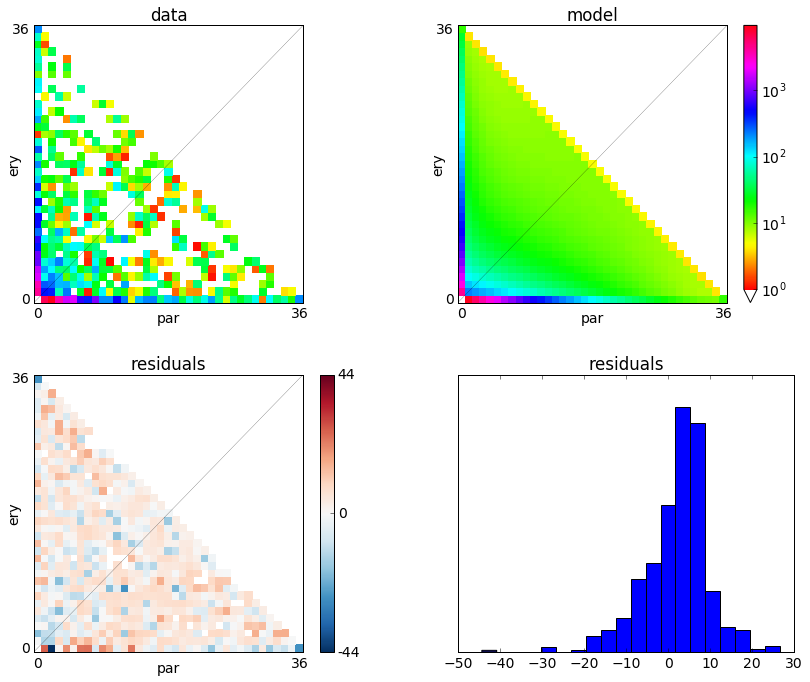

In [54]:
dadi.Plotting.plot_2d_comp_multinom(data=sfs2d, model=model, vmin=1)

I would like to compare the best-fit spectra of the _ancient migration_ with this _recent bottleneck_ model.

In [55]:
recent_bottleneck = dadi.Inference.optimally_scaled_sfs(model, sfs2d)

In [57]:
func_ex = dadi.Numerics.make_extrap_log_func(split_asym_mig)

popt_asym_mig = [ 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

model_asym_mig = func_ex(popt_asym_mig, ns, pts_l)

model_asym_mig = dadi.Inference.optimally_scaled_sfs(model_asym_mig, sfs2d)

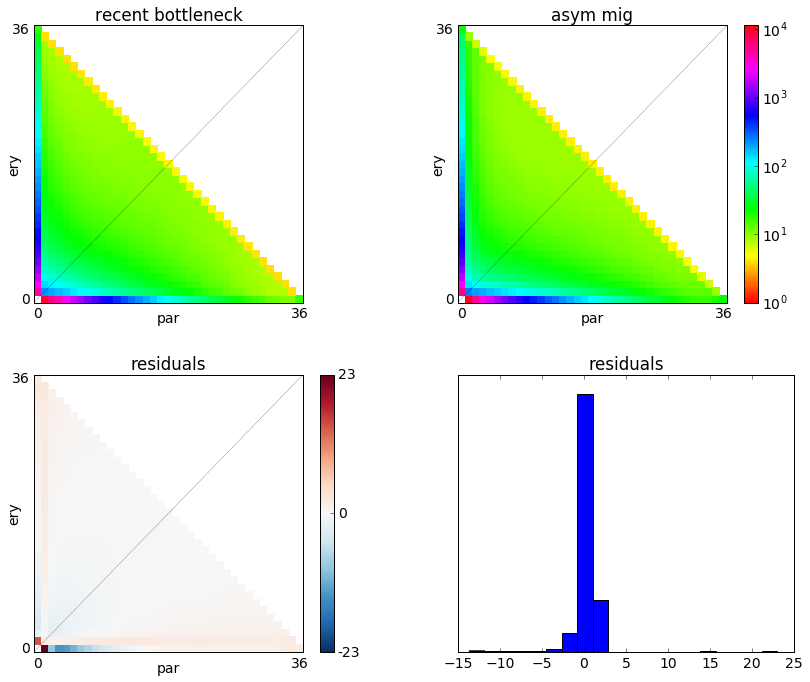

In [58]:
dadi.Plotting.plot_2d_comp_multinom(data=recent_bottleneck.fold() , model=model_asym_mig.fold(), \
                                    vmin=1, title=['recent bottleneck', 'asym mig'], pop_ids=['ery', 'par'])

The two predicted spectra under the two models mainly differ in their predictions for the SNP count classes [0, 1] and [1, 0]. This is also true when those two models are fit to the corrected spectrum.

# exponential size changes after split

I would now like to add a gradual population size change after the split of the ancestral population. So far, the split coincided with a stepwise population size change.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [3]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [4]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [5]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [7]:
%psource dadi.Demographics2D.IM

Dadi's built-in `IM` model function contains what I would like to model now. To avoid confusion of migration rate parameters, I am anyway going to specify a slightly modified version of this model that uses the same naming convention and order of _m_ as used above.

In [6]:
def IM(params, ns, pts):
    """
    ns = (n1,n2)
    params = (s,nu1,nu2,T,m1,m2)

    Isolation-with-migration model with exponential pop growth or decline.

    s: Size of pop 1 after split. (Pop 2 has size 1-s.)
    nu1: Final size of pop 1.
    nu2: Final size of pop 2.
    T: Time in the past of split (in units of 2*Na generations) 
    m1: Migration from pop 1 to pop 2
    m2: Migration from pop 2 to pop 1 (2*Na*m12)
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    s,nu1,nu2,T,m1,m2 = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)

    nu1_func = lambda t: s * (nu1/s)**(t/T)
    nu2_func = lambda t: (1-s) * (nu2/(1-s))**(t/T)
    phi = dadi.Integration.two_pops(phi, xx, T, nu1_func, nu2_func,
                               m12=m2, m21=m1)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

In [7]:
%who

Client	 IM	 cl	 dadi	 numpy	 sfs2d	 sfs2d_unfolded	 sys	 


In [8]:
cl[:].push(dict(IM=IM))

<AsyncResult: _push>

In [9]:
%%px --local

func = IM

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [10]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/IM" # set file name stub for opt. result files
fixed_params = None # do not fix any parameters, optimise all

In [11]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                        fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [12]:
lbview = cl.load_balanced_view()

In [13]:
from itertools import repeat

In [14]:
%%px --local

# set lower and upper bounds to s, nu1, nu2, T, m1, m2
upper_bound = [1, 1e4, 1e4, 4, 10, 10] # note, I have increased the upper bound for T
lower_bound = [0, 1e-4, 1e-4, 0, 0, 0]

In [15]:
# using optimal parameter values from `split_asym_mig` model as starting values to perturb
p0 = [0.5, 0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

In [20]:
#ar_IM = lbview.map(run_dadi, repeat(p0, 10), block=False, order=False)

In [16]:
from utility_functions import *

In [24]:
ar_IM.done()

True

In [25]:
ar_IM.elapsed/60

54.9877662

It took almost 55 minutes to run these 10 optimisations!

In [27]:
get_flag_count(ar_IM, NM=True)

success 0
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 10
unknown flag 0


None of these iterations were successfull!

Let's have a look at the final parameters anyway.

In [17]:
from glob import glob
import dill

In [29]:
ar_IM_1 = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM_1.append(dill.load((open(filename))))

In [18]:
import pandas as pd

In [31]:
l = 2*len(p0)+1

returned = [flatten(out)[:l] for out in ar_IM_1]

df = pd.DataFrame(data=returned, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
8,0.538469,1.255813,1.702693,0.635345,0.112638,0.259371,0.388115,1.063798,3.199012,3.234170,0.078406,0.557619,18814.877903
4,0.417002,0.379670,3.335798,1.655678,0.049658,0.456647,0.379121,1.082723,3.258400,3.404997,0.074637,0.545341,18815.329404
9,0.370682,0.321735,1.056795,0.583936,0.095256,0.255517,0.380064,1.084249,3.291107,3.415423,0.071002,0.551352,18815.491487
7,0.419080,0.329731,1.333254,0.328069,0.039567,0.583451,0.374416,0.861984,2.582981,2.194370,0.091604,0.687243,18824.198181
2,0.250917,1.848311,3.456539,3.836616,0.044460,1.623415,0.369875,0.847265,2.495861,1.992395,0.095853,0.694150,18827.183941
3,0.352691,0.420037,1.332921,1.209721,0.021299,1.610173,0.967013,0.426826,1.563459,3.937736,0.126149,1.350203,18872.325721
5,0.990000,1.262332,1.557653,0.404441,0.035836,0.379532,0.931879,0.497042,1.822031,3.908742,0.108858,1.162796,18873.343595
0,0.349074,0.946208,0.695694,1.037682,0.026119,0.684564,0.367520,0.831470,2.163526,1.064547,0.124656,0.680121,18922.856747
6,0.990000,0.618494,1.587982,0.834066,0.034694,0.726777,0.937755,0.255256,0.986855,1.923004,0.171459,2.263183,18928.836496
1,0.561863,3.449307,0.654947,3.505459,0.037483,0.875936,0.360894,0.970010,2.247817,1.386019,0.152528,0.521075,19022.057461


Note, that the _opt_ parameter values are just the final parameter values when the optimisation aborted. The parameter combinations with the highest likelihood have extremely long divergence time _T_. Also, the best-fit parameter combination of the `split_asym_mig` model above had log-likelihood of -18104, i. e. MUCH higher than the best parameter combination returned here.

In [32]:
cl[0]['fold']

2

In [33]:
cl[0]['maxiter']

300

In [34]:
%%px

fold = 1
maxiter = 500

In [35]:
#ar_IM = lbview.map(run_dadi, repeat(p0, 10), block=False, order=False)

In [36]:
ar_IM.done()

True

In [37]:
ar_IM.elapsed/60

25.25407435

In [38]:
get_flag_count(ar_IM, NM=True)

success 6
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 4
unknown flag 0


6 optimisations were successfull.

In [39]:
ar_IM_2 = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM_2.append(dill.load((open(filename))))

In [41]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_IM_2 if out[1][4] == 0]

df = pd.DataFrame(data=success, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
1,0.691487,0.915053,3.337032,0.675904,0.163826,0.807328,0.401345,1.127900,3.433437,3.748322,0.069455,0.527414,18815.275911
0,0.480835,0.544289,2.698495,1.274298,0.108224,0.268005,0.386625,0.783977,2.312601,1.617469,0.106002,0.737586,18840.777647
2,0.311248,0.783400,1.527702,1.510593,0.097480,0.531996,0.379276,0.775452,2.276909,1.521873,0.107318,0.746463,18844.827051
5,0.256491,0.509203,1.193839,1.769454,0.052319,0.549816,0.360170,0.752934,2.103795,1.277866,0.118310,0.756747,18863.418261
4,0.340653,0.603664,2.743283,1.991499,0.100978,0.949964,0.389427,0.650453,2.072952,1.319869,0.093361,0.918291,18895.525183
3,0.724210,1.404692,1.981255,1.471683,0.043129,0.520545,0.432212,0.674174,1.857634,0.754107,0.141318,0.734668,18936.354679


The optimsations have not converged on a set of optimal parameter values.

In [42]:
cl[:]['fold']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [43]:
p0

[0.5, 0.92091098, 2.2386172, 1.24468148, 0.08414741, 0.49491818]

In [44]:
%%px

fold = 1.5

In [45]:
ar_IM = lbview.map(run_dadi, repeat(p0, 20))

In [20]:
ar_IM_3 = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM_3.append(dill.load((open(filename))))

In [21]:
l = 2*len(p0)+1

success = [flatten(out)[:l] for out in ar_IM_3 if out[1][4] == 0]

df = pd.DataFrame(data=success, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
5,0.345561,0.585417,1.192358,0.584863,0.042089,0.583673,0.409575,1.037432,3.163748,3.314343,0.075790,0.574198,18814.902965
4,0.691487,0.915053,3.337032,0.675904,0.163826,0.807328,0.401345,1.127900,3.433437,3.748322,0.069455,0.527414,18815.275911
2,0.231016,1.236144,1.875334,1.265815,0.065793,0.251310,0.389511,0.968089,2.940081,2.803636,0.082062,0.612002,18815.733030
13,0.222590,0.812110,1.404866,1.332359,0.031135,1.195093,0.424820,0.974611,3.066101,3.252257,0.074601,0.609123,18818.545393
8,0.874340,0.961087,3.051648,3.520197,0.075565,0.176083,0.497492,0.984338,3.197253,3.792882,0.069817,0.601396,18824.987400
6,0.588433,2.181412,2.425662,3.218246,0.032654,0.752488,0.567327,0.936764,3.089310,3.876621,0.073644,0.626325,18832.714699
0,0.480835,0.544289,2.698495,1.274298,0.108224,0.268005,0.386625,0.783977,2.312601,1.617469,0.106002,0.737586,18840.777647
7,0.311248,0.783400,1.527702,1.510593,0.097480,0.531996,0.379276,0.775452,2.276909,1.521873,0.107318,0.746463,18844.827051
15,0.256491,0.509203,1.193839,1.769454,0.052319,0.549816,0.360170,0.752934,2.103795,1.277866,0.118310,0.756747,18863.418261
9,0.767327,0.948644,2.160534,1.910986,0.054061,1.040162,0.371058,0.668971,2.138476,1.450574,0.090520,0.895524,18883.712912


This model is hard to fit to the data. The best-fit parameter combinations contain an extremely long divergence time _T_ of around 3, i. e. $6 \times N_{ref}$ generations. No parameter combination with higher likelihood could be found than in the previous runs and they are all much lower than from the `split_asym_mig` model (-18104), which imposed a stepwise size change coincident with the population split and otherwise constant population sizes. I do not understand why this more flexible model is so much harder to fit to the data.

In section 6, I have noticed that final parameter combinations from "unsuccessfull" optimisations can have higher likelihood than parameter combinations from successfull optimisations. I am therefore going to load the final parameter combinations from all "unsuccessfull" optimisations from file in order to check whether some have higher likelihood than the ones seen so far.

In [39]:
from glob import glob
import dill

In [41]:
ar_IM = []

for filename in glob("OUT_2D_models/IM*dill"):
    ar_IM.append(dill.load((open(filename))))

In [42]:
import pandas as pd

In [45]:
l = 2*6+1

# get all paramters returned from " unsuccessfull" optimisations into a table
returned = [flatten(out)[:l] for out in ar_IM if out[1][4] != 0]

df = pd.DataFrame(data=returned, columns=['s_0' ,'nu1_0','nu2_0', 'T_0', 'm1_0', 'm2_0', 's_opt' ,'nu1_opt', 'nu2_opt', 'T_opt', 'm1_opt', 'm2_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head()

,s_0,nu1_0,nu2_0,T_0,m1_0,m2_0,s_opt,nu1_opt,nu2_opt,T_opt,m1_opt,m2_opt,-logL
13,0.287604,0.584816,2.491513,0.577716,0.154881,0.912029,0.394336,1.028757,3.117404,3.130620,0.077685,0.576641,18814.402521
0,0.463402,0.738050,3.905796,0.739800,0.058625,0.441791,0.406139,1.080665,3.270704,3.494185,0.074393,0.547156,18814.762357
20,0.538469,1.255813,1.702693,0.635345,0.112638,0.259371,0.388115,1.063798,3.199012,3.234170,0.078406,0.557619,18814.877903
10,0.417002,0.379670,3.335798,1.655678,0.049658,0.456647,0.379121,1.082723,3.258400,3.404997,0.074637,0.545341,18815.329404
22,0.370682,0.321735,1.056795,0.583936,0.095256,0.255517,0.380064,1.084249,3.291107,3.415423,0.071002,0.551352,18815.491487


No better parameter combinations can be found here.

In [23]:
import numpy as np

In [34]:
popt = np.array(df.sort_values(by='-logL', ascending=True).iloc[0, 6:12])
popt

array([ 0.40957519,  1.03743151,  3.16374756,  3.31434324,  0.07579024,
        0.57419769])

In [35]:
%psource IM

In [36]:
func_ex = dadi.Numerics.make_extrap_log_func(IM)

model_spectrum = func_ex(popt, ns, pts_l)

## Plot

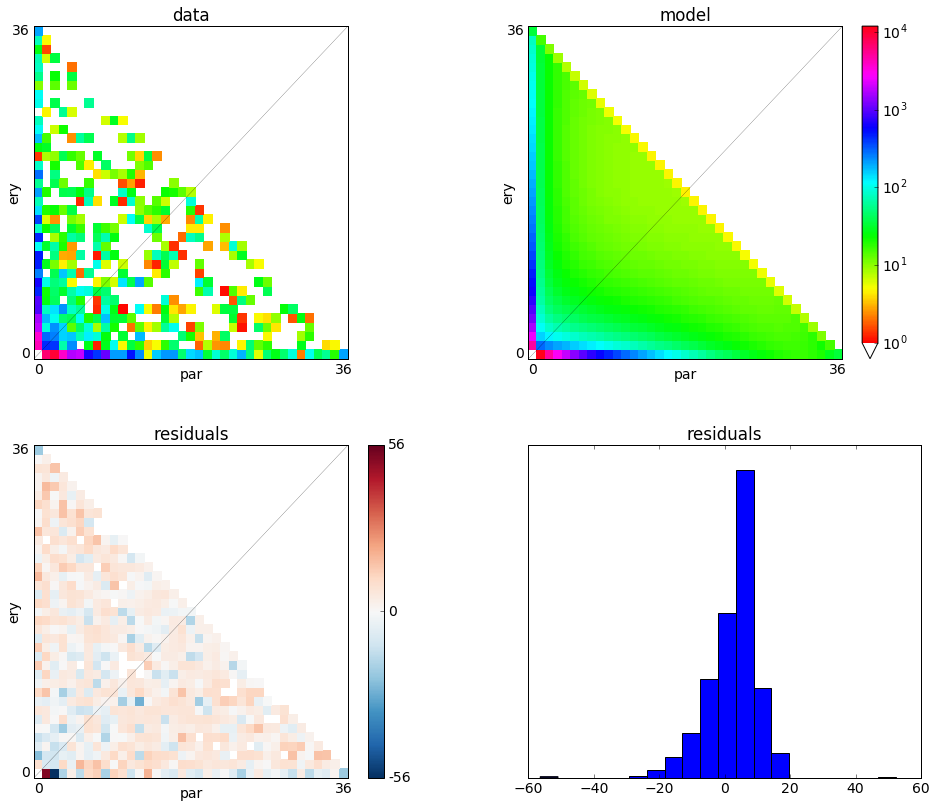

In [37]:
dadi.Plotting.plot_2d_comp_multinom(model_spectrum, sfs2d, vmin=1)

I would like to see the difference in the expected spectra from the `split_asym_mig` and this `IM` model.

In [42]:
# optimally scale the best-fit IM model spectrum,
# by multiplication with optimal theta
model_spectrum = dadi.Inference.optimally_scaled_sfs(model_spectrum, sfs2d)

In [43]:
# make extraplating function from `split_asym_mig` model function
func_ex = dadi.Numerics.make_extrap_log_func(split_asym_mig)

# these were the optimal parameters for the `split_asym_mig` model
popt_asym_mig = [0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

# get (unsclaed) expected SFS for optimal `split_asym_mig` model
model_spectrum_asym_mig = func_ex(popt_asym_mig, ns, pts_l)

# optimally scale spectrum
model_spectrum_asym_mig = dadi.Inference.optimally_scaled_sfs(model_spectrum_asym_mig, sfs2d)

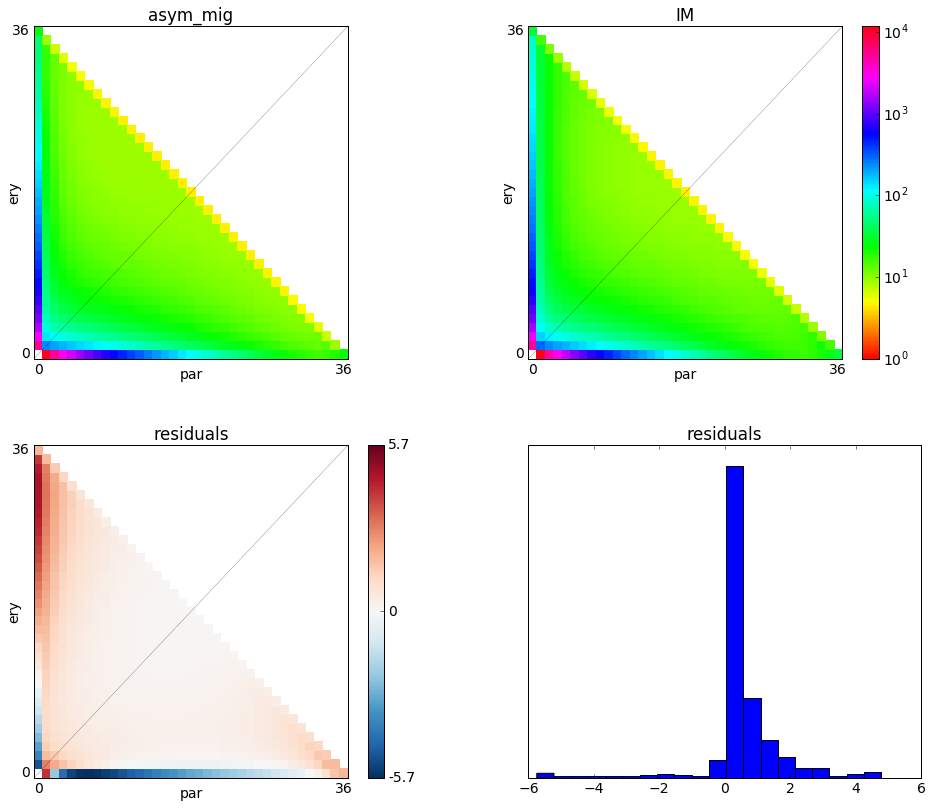

In [48]:
dadi.Plotting.plot_2d_comp_multinom(data=model_spectrum_asym_mig.fold(), model=model_spectrum.fold(), \
                                    vmin=1, title=['asym_mig', 'IM'], pop_ids=['ery', 'par'])

Looking at the residual plot, the `IM` model has a deficit (blue) of low frequency private alleles in par and an excess (red) of high frequency private alleles in ery.

# Ancient migration model

So far, a model with an ancient split and low but constant gene flow (more from par into ery than in the other direction) has fit the data best. I would like to know whether I can achieve an improvement if I let gene flow cease completely at some point in time.

In [37]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [38]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

In [39]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [40]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [41]:
import numpy as np

In [42]:
def split_asym_mig_iso(params, ns, pts):
    """
    params = (nu1,nu2,Tc,m1,m2,Ti)
    ns = (n1,n2)

    Split into two populations of specifed size, with potentially asymmetric migration
    for a time Tc followed by complete isolation until present.

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    Tc: Time of gene flow after split (in units of 2*Na generations) 
    m1: Migration rate from ery into par (in units of 2*Na ind per generation)
    m2: Migration rate from par into ery (in units of 2*Na ind per generation)
    Ti: Time of isolation after cessation of gene flow
    The split lies Tc+Ti * 2Na generations in the past.
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,Tc,m1,m2,Ti = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    
    # split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) 
    
    # divergence with potentially asymmetric migration
    phi = dadi.Integration.two_pops(phi, xx, Tc, nu1, nu2, m12=m2, m21=m1)
    
    # divergence without gene flow
    phi = dadi.Integration.two_pops(phi, xx, Ti, nu1, nu2, m12=0, m21=0)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

This is a piecewise model. I could make gene flow fade out gradually, but that would require four migration parameters that specify the initial and final levels of gene flow for each direction. Also, it would make the model less comparable to the `split_asym_mig` model, which is also piecewise.

In [43]:
cl[:].push(dict(split_asym_mig_iso=split_asym_mig_iso))

<AsyncResult: _push>

In [44]:
%%px --local

func = split_asym_mig_iso

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [45]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_asym_mig_iso" # set file name stub for opt. result files
fixed_params = None

In [46]:
%%px --local

# set lower and upper bounds to nu1, nu2, Tc, m1, m2 and Ti
upper_bound = [1e4, 1e4, 4, 10, 10, 4] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0, 0]

In [47]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                        fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [48]:
lbview = cl.load_balanced_view()

In [49]:
from itertools import repeat

In [21]:
# these were the optimal parameters for the `split_asym_mig` model
popt_asym_mig = [0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

p0 = [0.92091098,  2.2386172 ,  1.24468148/2,  0.08414741,  0.49491818, 1.24468148/2]

In [17]:
#ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [18]:
from utility_functions import *

In [19]:
get_flag_count(ar_split_asym_mig_iso, NM=True)

success 2
Maximum number of function evaluations made. 0
Maximum number of iterations reached. 8
unknown flag 0


In [19]:
from glob import glob
import dill

ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [20]:
import pandas as pd

In [22]:
l = 2*len(p0)+1

# show only successfull optimisations
success = [flatten(out)[:l] for out in ar_split_asym_mig_iso if out[1][4] == 0]

df = pd.DataFrame(data=success, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
0,2.304194,4.429762,0.321067,0.088034,0.164105,1.145286,0.636636,1.230704,0.000361,0.000260,0.150317,0.290324,20387.374998
1,0.491139,8.116228,0.412795,0.028315,0.164313,1.385604,0.637813,1.229741,0.000072,0.508703,2.303400,0.290336,20387.455689


In [23]:
l = 2*len(p0)+1

# show parameter combinations from unsuccessfull optimisations:
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso if out[1][4] != 0]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
1,0.695160,1.910340,0.349480,0.079170,1.213752,0.452250,1.308976,3.255343,2.529225,7.601761e-02,0.512996,0.073343,17596.977545
3,0.671653,4.065260,2.194221,0.023455,0.353608,0.309520,1.282689,3.178194,2.456849,7.839336e-02,0.523647,0.071873,17598.109544
2,1.167491,2.210074,0.958929,0.029067,0.549556,0.158691,1.429102,3.584991,2.968951,6.605450e-02,0.457774,0.075285,17599.537780
7,2.441785,6.229020,0.730805,0.292610,0.622232,1.322095,1.220463,2.887035,2.149251,8.576529e-02,0.535093,0.060766,17614.184508
0,1.065453,6.333377,0.201816,0.038520,0.652852,0.315942,1.105729,2.695073,1.943358,9.068463e-02,0.606128,0.064713,17614.359180
6,2.649187,0.834484,0.679590,0.050556,1.111954,0.443331,1.039608,3.032459,1.984307,1.552506e-24,0.751166,0.062413,17930.613992
4,1.453066,2.898464,0.189121,0.062543,0.175887,0.213037,1.087550,3.193930,2.211338,3.755145e-05,0.749341,0.069638,17934.636212
5,0.392916,8.638236,0.548424,0.057429,0.832261,1.290279,0.637745,1.229895,0.000028,2.568636e-12,8.924231,0.290417,20387.440766


This is strange. "Unsuccessfull" optimisations (those which were aborted due to `Maximum number of iterations reached`) return parameter combinations that are much better than the two successfull optimisations!

**I wonder how many good parameter combinations I have missed due to my discarding of "unsuccessfull" optimisations!**

Fortunately, I have saved the results of _all_ optimisations to disk. So I can check each of my model optimisations for previously missed parameter combinbations that are better than the ones I have found so far.

The log likelihood of the `split_asym_mig` model with best-fit parameters was: -18104.966266885222

In [29]:
D = 2*(-17596.977545 - -18104.966266885222)
D

1015.97744377044

This ancient migration model fits the data significantly better than the `split_asym_mig` model. That also means that the recent period of complete isolation is significant. Assuming that I had found the best-fit parameters for that model, this means that a model that allows for a very ancient split (>1 million generations ago) and that specifies a recent cessation of gene flow fits the data better than a model with a less ancient split and constant migration until present.

Let's get a few more optimisation results.

In [24]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,6:12])
p0

array([ 1.30897621,  3.25534314,  2.52922477,  0.07601761,  0.51299594,
        0.0733433 ])

In [25]:
ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [26]:
ar_split_asym_mig_iso.elapsed/60

11.90408875

In [27]:
ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [28]:
l = 2*len(p0)+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
18,4.519198,3.545465,3.960000,0.182724,0.328545,0.251493,1.724821,4.216882,3.678057,0.064336,0.396156,0.103548,17586.638813
5,0.695160,1.910340,0.349480,0.079170,1.213752,0.452250,1.308976,3.255343,2.529225,0.076018,0.512996,0.073343,17596.977545
19,2.290455,5.739002,1.606897,0.029919,0.482170,0.058327,1.305280,3.197046,2.481270,0.082010,0.522732,0.078352,17597.039999
9,0.671653,4.065260,2.194221,0.023455,0.353608,0.309520,1.282689,3.178194,2.456849,0.078393,0.523647,0.071873,17598.109544
6,1.167491,2.210074,0.958929,0.029067,0.549556,0.158691,1.429102,3.584991,2.968951,0.066055,0.457774,0.075285,17599.537780
2,1.829076,1.705655,3.960000,0.019067,0.842192,0.042996,1.130924,2.812528,2.015328,0.088408,0.592335,0.063364,17609.081716
17,2.441785,6.229020,0.730805,0.292610,0.622232,1.322095,1.220463,2.887035,2.149251,0.085765,0.535093,0.060766,17614.184508
1,1.065453,6.333377,0.201816,0.038520,0.652852,0.315942,1.105729,2.695073,1.943358,0.090685,0.606128,0.064713,17614.359180
10,0.932752,10.540588,1.824403,0.160051,0.458349,0.096989,0.925794,2.354674,1.503445,0.093921,0.719264,0.051874,17646.117157
0,2.216917,9.316636,1.197507,0.151019,0.291777,0.264858,0.860188,2.083049,1.160227,0.119236,0.762025,0.051645,17696.366407


There seems to be decent convergence. The long time inferred for the split ($T_c+T_i$) is worrying. I think it would be good to start a few more optimisations around the best parameter combination.

In [29]:
%%px 

fold = 1

In [30]:
p0 = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,6:12])
p0

array([ 1.72482052,  4.21688238,  3.67805724,  0.06433563,  0.39615551,
        0.10354805])

In [31]:
#ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [55]:
% ll OUT_2D_models/split_asym_mig_iso*dill

-rw-rw-r-- 1 claudius 348 May 21 10:43 OUT_2D_models/split_asym_mig_iso_0.3471_1.6699_3.9600_0.0319_1.5389_0.2347.dill
-rw-rw-r-- 1 claudius 348 May 20 17:41 OUT_2D_models/split_asym_mig_iso_0.3929_8.6382_0.5484_0.0574_0.8323_1.2903.dill
-rw-rw-r-- 1 claudius 348 May 20 17:41 OUT_2D_models/split_asym_mig_iso_0.4911_8.1162_0.4128_0.0283_0.1643_1.3856.dill
-rw-rw-r-- 1 claudius 348 May 21 10:38 OUT_2D_models/split_asym_mig_iso_0.5024_5.2861_0.8758_0.3004_0.2243_0.0354.dill
-rw-rw-r-- 1 claudius 348 May 20 17:45 OUT_2D_models/split_asym_mig_iso_0.6717_4.0653_2.1942_0.0235_0.3536_0.3095.dill
-rw-rw-r-- 1 claudius 348 May 20 17:45 OUT_2D_models/split_asym_mig_iso_0.6952_1.9103_0.3495_0.0792_1.2138_0.4522.dill
-rw-rw-r-- 1 claudius 348 May 21 11:06 OUT_2D_models/split_asym_mig_iso_0.8864_6.0404_3.9600_0.0349_0.3026_0.2061.dill
-rw-rw-r-- 1 claudius 348 May 21 11:06 OUT_2D_models/split_asym_mig_iso_0.9193_3.9003_2.7604_0.1177_0.2960_0.0899.dill
-rw-rw-r-- 1 claudius 348 May 21 10:41 OUT_2D_mo

In [56]:
ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [57]:
l = 2*6+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
6,3.311864,5.144676,3.960000,0.109423,0.383802,0.129523,1.798721,4.397479,3.879859,0.061955,0.379276,0.107981,17585.882553
29,1.642916,6.103883,3.960000,0.054931,0.349428,0.058007,1.781764,4.362300,3.835582,0.062103,0.383396,0.106964,17586.026218
26,4.519198,3.545465,3.960000,0.182724,0.328545,0.251493,1.724821,4.216882,3.678057,0.064336,0.396156,0.103548,17586.638813
9,0.919254,3.900315,2.760405,0.117729,0.296027,0.089884,1.812170,4.400267,3.940908,0.062024,0.372393,0.108010,17586.805601
16,1.392965,3.383226,3.944028,0.052414,0.283459,0.073705,1.644600,4.027544,3.413685,0.066863,0.414662,0.098731,17587.978896
21,2.236010,2.136647,1.937628,0.095886,0.198439,0.059026,1.598186,3.923935,3.315448,0.068340,0.427212,0.095945,17588.376031
19,1.345651,2.234866,3.960000,0.035002,0.245472,0.081826,1.405393,3.451940,2.778376,0.076471,0.485692,0.084368,17592.877099
2,2.298750,5.108041,2.237167,0.071726,0.568041,0.171407,1.399617,3.439860,2.760202,0.076696,0.488590,0.084021,17593.096129
14,1.640028,6.001613,3.960000,0.078795,0.642601,0.093519,1.379659,3.393278,2.703678,0.076974,0.495791,0.082824,17593.774540
28,1.110873,7.672557,3.960000,0.063787,0.508132,0.083784,1.349127,3.342863,2.637726,0.080427,0.512762,0.080979,17596.732548


This looks like decent convergence. I would like to refine the search by using a finer grid.

In [50]:
%%px --local

# set lower and upper bounds to nu1, nu2, Tc, m1, m2 and Ti
upper_bound = [1e4, 1e4, 6, 10, 10, 4] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0, 0]

In [51]:
%%px 

fold = 1
pts_l = [50, 60, 70]
maxiter = 300

In [58]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,6:12])
popt

array([ 1.79872058,  4.39747881,  3.87985883,  0.06195513,  0.37927635,
        0.10798109])

In [59]:
p0 = popt

#ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10))

In [60]:
ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [61]:
l = 2*6+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
14,2.457166,7.524601,5.393413,0.108182,0.288238,0.119209,2.439955,5.984046,5.708981,0.045731,0.279332,0.146457,17583.559438
9,2.988730,4.738118,4.034295,0.054839,0.356824,0.157766,2.092882,5.117888,4.727453,0.053452,0.326719,0.125626,17584.511983
38,2.942805,4.976983,2.734166,0.069029,0.212524,0.093116,2.033029,4.975807,4.562200,0.054811,0.336354,0.122034,17584.788795
8,3.311864,5.144676,3.960000,0.109423,0.383802,0.129523,1.798721,4.397479,3.879859,0.061955,0.379276,0.107981,17585.882553
28,2.097129,5.327970,5.500053,0.083428,0.525671,0.092544,1.842790,4.510400,4.019504,0.060138,0.371075,0.110615,17586.022421
36,1.642916,6.103883,3.960000,0.054931,0.349428,0.058007,1.781764,4.362300,3.835582,0.062103,0.383396,0.106964,17586.026218
33,4.519198,3.545465,3.960000,0.182724,0.328545,0.251493,1.724821,4.216882,3.678057,0.064336,0.396156,0.103548,17586.638813
13,0.919254,3.900315,2.760405,0.117729,0.296027,0.089884,1.812170,4.400267,3.940908,0.062024,0.372393,0.108010,17586.805601
11,2.390058,3.266445,3.303982,0.031797,0.414153,0.176817,1.750585,4.282384,3.759859,0.063111,0.390825,0.105080,17586.889026
22,1.392965,3.383226,3.944028,0.052414,0.283459,0.073705,1.644600,4.027544,3.413685,0.066863,0.414662,0.098731,17587.978896


$T_C$ is close to the upper bound of 6 that I have set. Although it is hard to believe in such high values of a time parameter, I am going to increase the bound and run a few more optimisations. If the next optimisations are again close the now increased boundary, I am declaring the optimisation failed.

In [67]:
%%px --local

# set lower and upper bounds to nu1, nu2, Tc, m1, m2 and Ti
upper_bound = [1e4, 1e4, 8, 10, 10, 4] # note, I have increased the upper bound for T

In [65]:
%%px 

fold = 1
pts_l = [50, 60, 70]
maxiter = 100

In [66]:
popt = np.array(df.sort_values(by='-logL', ascending=True).head(10).iloc[0,6:12])
popt

array([ 2.43995478,  5.98404638,  5.70898056,  0.04573105,  0.27933204,
        0.14645712])

In [68]:
p0 = popt

#ar_split_asym_mig_iso = lbview.map(run_dadi, repeat(p0, 10), block=False)

In [71]:
ar_split_asym_mig_iso.done()

True

In [72]:
ar_split_asym_mig_iso = []

for filename in glob("OUT_2D_models/split_asym_mig_iso*dill"):
    ar_split_asym_mig_iso.append(dill.load(open(filename)))

In [73]:
l = 2*6+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_split_asym_mig_iso]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,-logL
38,3.122675,6.565590,4.556457,0.025178,0.150502,0.193779,2.884250,7.039549,6.939774,0.039132,0.237419,0.173159,17582.884413
15,2.457166,7.524601,5.393413,0.108182,0.288238,0.119209,2.439955,5.984046,5.708981,0.045731,0.279332,0.146457,17583.559438
6,3.803361,5.073436,4.055461,0.089821,0.147407,0.074291,2.507140,6.203819,6.007240,0.042590,0.272537,0.148739,17584.306651
10,2.988730,4.738118,4.034295,0.054839,0.356824,0.157766,2.092882,5.117888,4.727453,0.053452,0.326719,0.125626,17584.511983
48,2.942805,4.976983,2.734166,0.069029,0.212524,0.093116,2.033029,4.975807,4.562200,0.054811,0.336354,0.122034,17584.788795
37,1.698863,3.380579,5.956428,0.041756,0.236200,0.099436,2.012841,4.921590,4.465928,0.055141,0.338755,0.120221,17585.405692
9,3.311864,5.144676,3.960000,0.109423,0.383802,0.129523,1.798721,4.397479,3.879859,0.061955,0.379276,0.107981,17585.882553
25,3.772272,5.313562,3.820628,0.075429,0.294183,0.246429,2.276085,5.525343,5.185373,0.051899,0.292315,0.134893,17585.939796
34,2.097129,5.327970,5.500053,0.083428,0.525671,0.092544,1.842790,4.510400,4.019504,0.060138,0.371075,0.110615,17586.022421
46,1.642916,6.103883,3.960000,0.054931,0.349428,0.058007,1.781764,4.362300,3.835582,0.062103,0.383396,0.106964,17586.026218


It is difficult to achieve convergence. Parameter combinations with quite different time of primary contact ($T_C$) have very similar likelihood.

## plot

In [76]:
popt_mig_iso = np.array(df.sort_values(by='-logL', ascending=True).iloc[0,6:12])
popt_mig_iso

array([ 2.8842495 ,  7.03954944,  6.93977407,  0.03913244,  0.23741935,
        0.1731595 ])

In [77]:
model_mig_iso = func_ex(popt_mig_iso, ns, pts_l)

In [78]:
%matplotlib inline

import pylab

pylab.rcParams['figure.figsize'] = [14, 12]
pylab.rcParams['font.size'] = 14

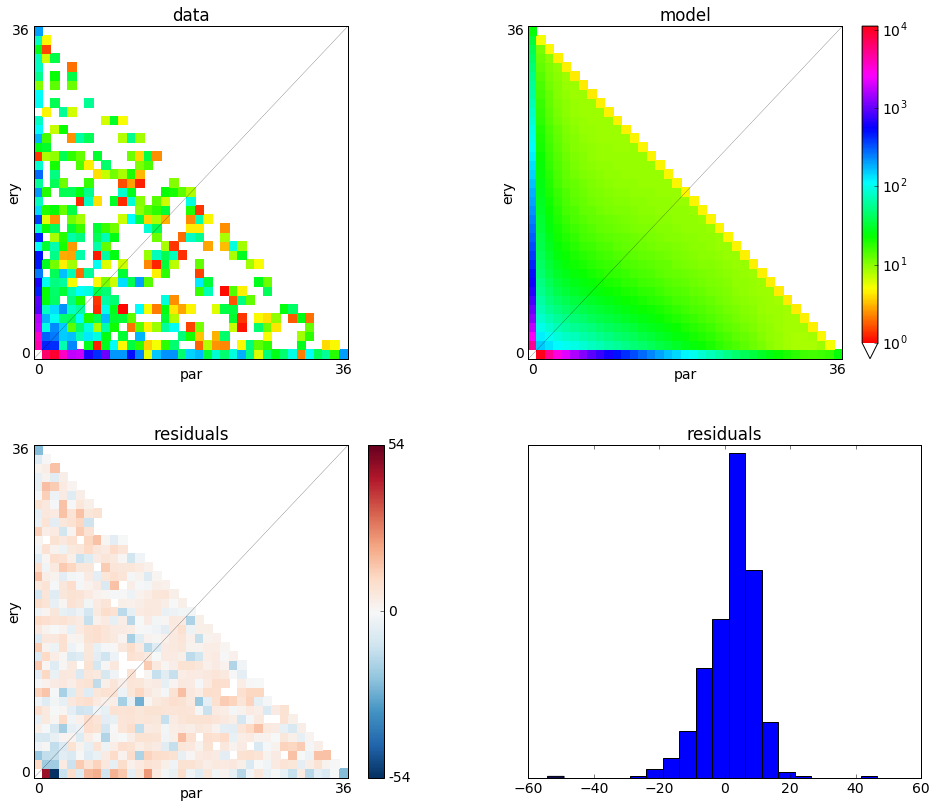

In [79]:
dadi.Plotting.plot_2d_comp_multinom(model=model_mig_iso, data=sfs2d, vmin=1)

## plain English

In [80]:
theta = dadi.Inference.optimal_sfs_scaling(model_mig_iso, sfs2d)
theta

1709.4208758269674

In [81]:
mu = 3e-9
L = sfs2d.data.sum() # this sums over all entries in the spectrum, including masked ones, i. e. also contains invariable sites
print "The total sequence length for the 2D spectrum is {0:,}.".format(int(L))
N_ref = theta/L/mu/4
print "The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: {0:,}.".format(int(N_ref))

The total sequence length for the 2D spectrum is 1,130,775.
The effective size of the ancestral population of ery and par (in number of diploid individuals) implied by this theta is: 125,977.


I think those long inferred divergence times lead to a reduction in the estimated theta.

In [82]:
popt = popt_mig_iso
print "The ancestral population split apart {0:,} generations ago.".format(int((popt[2]+popt[5])*2*N_ref)),
print "Immediately after the split the ERY population changed to a size of {0:,} and the PAR population to {1:,}.".format(int(popt[0]*N_ref), int(popt[1]*N_ref)),
print "Since the split of the ancestral population, PAR received 1 individual from ERY every {0:.2f} generations,".format(1.0/(popt[3]/2*popt[1])),
print "while ERY received 1 PAR individual every {0:.2f} generations.".format(1.0/(popt[4]/2*popt[0])),
print "Put another way: The par population contained a constant proportion of {0:.2e} of new immigrant alleles each generation".format(popt[3]/2/N_ref),
print "and the ery population contained a constant proportion of {0:.2e} of new immigrant alleles each generation.".format(popt[4]/2/N_ref),
print "ERY and PAR remained in contact for {0:,} generations.".format(int(popt[2]*2*N_ref)),
print "{0:,} generations ago gene flow between ERY and PAR had ceased.".format(int(popt[5]*2*N_ref))

The ancestral population split apart 1,792,133 generations ago. Immediately after the split the ERY population changed to a size of 363,349 and the PAR population to 886,821. Since the split of the ancestral population, PAR received 1 individual from ERY every 7.26 generations, while ERY received 1 PAR individual every 2.92 generations. Put another way: The par population contained a constant proportion of 1.55e-07 of new immigrant alleles each generation and the ery population contained a constant proportion of 9.42e-07 of new immigrant alleles each generation. ERY and PAR remained in contact for 1,748,505 generations. 43,628 generations ago gene flow between ERY and PAR had ceased.


See 2D_model_synthesis for correct parameter translations.

This is another indication that a recent secondary contact model is not compatible with the data. If the better fit of this ancient migration model (compared to constant migration) is not just due to fitting noise or biases in the data, then it would also mean that there is no detectable gene flow since the last ice age, despite the fact that the two populations are just a few kilometers apart and the clines of several markers are very wide across this transect of the hybrid zone.

## comparison with `split_asym_mig`

In [57]:
model_mig_iso_scaled = dadi.Inference.optimally_scaled_sfs(model_mig_iso, sfs2d)

In [59]:
func_ex = dadi.Numerics.make_extrap_log_func(split_asym_mig)

In [60]:
popt_asym_mig = [0.92091098,  2.2386172 ,  1.24468148,  0.08414741,  0.49491818]

In [61]:
model_asym_mig = func_ex(popt_asym_mig, ns, pts_l)

In [62]:
model_asym_mig_scaled = dadi.Inference.optimally_scaled_sfs(model_asym_mig, sfs2d)

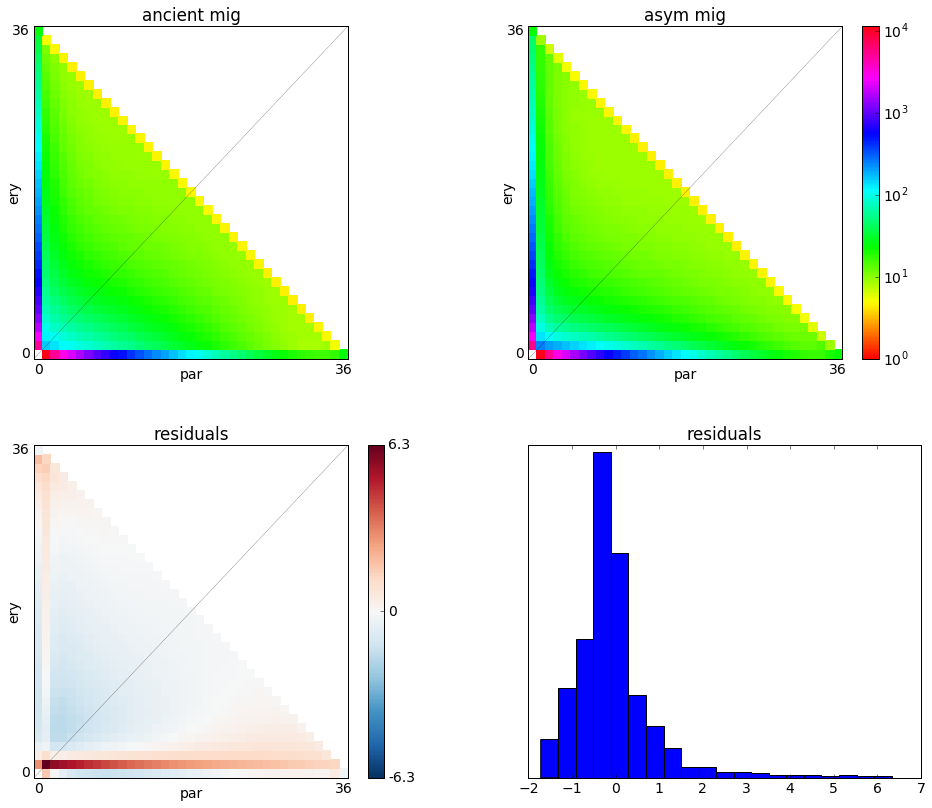

In [64]:
dadi.Plotting.plot_2d_comp_multinom(data=model_mig_iso_scaled.fold() , model=model_asym_mig_scaled.fold(), vmin=1, title=['ancient mig', 'asym mig'], pop_ids=['ery', 'par'])

Apparently the constant asymmetric migration model predicts many more variants at frequency 1 in erythropus than the ancient asymmetric migration model.

# ancient migration, isolation and secondary contact

I would like to see whether the fit to the data can be further improved if I add to the previous model a third epoch with a recent restart of gene flow.

In [1]:
from ipyparallel import Client

cl = Client()

cl.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [2]:
%%px --local

# run whole cell on all engines a well as in the local IPython session

import numpy

import sys

sys.path.insert(0, '/home/claudius/Downloads/dadi')

import dadi

error in importing Two Locus modules


In [3]:
%%px --local

# import 2D unfolded spectrum

sfs2d_unfolded = dadi.Spectrum.from_file('dadiExercises/EryPar.unfolded.2dsfs.dadi_format')

In [4]:
%%px --local

# add population labels
sfs2d_unfolded.pop_ids = ["ery", "par"]

sfs2d = sfs2d_unfolded.fold()

In [5]:
def split_mig_iso_mig(params, ns, pts):
    """
    params = (nu1,nu2,Tc,m1,m2,Ti,Tsc)
    ns = (n1,n2)

    Split into two populations of specifed size, with potentially asymmetric migration
    for a time Tc followed by a period of complete isolation Ti which is followed by a restart of
    migration until present. Migration rates in the two epochs are assumed be to equal (and constant).

    nu1: Size of population 1 after split.
    nu2: Size of population 2 after split.
    Tc: Time of gene flow after split (in units of 2*Na generations) 
    m1: Migration rate from ery into par (in units of 2*Na ind per generation)
    m2: Migration rate from par into ery (in units of 2*Na ind per generation)
    Ti: Time of isolation after cessation of gene flow
    Tsc: Time of gene flow after period of isolation until present
    
    The split lies Tc+Ti+Tsc * 2Na generations in the past.
    
    n1,n2: Sample sizes of resulting Spectrum
    pts: Number of grid points to use in integration.
    """
    nu1,nu2,Tc,m1,m2,Ti,Tsc = params

    xx = dadi.Numerics.default_grid(pts)

    phi = dadi.PhiManip.phi_1D(xx)
    
    # split
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi) 
    
    # divergence with potentially asymmetric migration
    phi = dadi.Integration.two_pops(phi, xx, Tc, nu1, nu2, m12=m2, m21=m1)
    
    # divergence without gene flow
    phi = dadi.Integration.two_pops(phi, xx, Ti, nu1, nu2, m12=0, m21=0)
    
    # divergence with potentially asymmetric migration
    phi = dadi.Integration.two_pops(phi, xx, Tsc, nu1, nu2, m12=m2, m21=m1)

    fs = dadi.Spectrum.from_phi(phi, ns, (xx,xx))
    return fs

This model just adds another epoch to the ancient migration model in the previous section. The period without gene flow is now followed by another period where gene flow recommences and lasts until the present. Note that migration rates are assumed to be the same in both epochs of gene flow.

In [6]:
cl[:].push(dict(split_mig_iso_mig=split_mig_iso_mig))

<AsyncResult: _push>

In [7]:
%%px --local

func = split_mig_iso_mig

func_ex = dadi.Numerics.make_extrap_log_func(func)

In [8]:
%%px --local

# set up global variables on engines required for run_dadi function call

ns = sfs2d.sample_sizes # both populations have the same sample size
# setting the smallest grid size slightly larger than the largest population sample size (36)
pts_l = [40, 50, 60]
dadi_opt_func = dadi.Inference.optimize_log_fmin # uses Nelder-Mead algorithm
sfs = sfs2d
perturb = True
fold = 2 # perturb randomly up to `fold` times 2-fold
maxiter = 300 # run a maximum of 300 iterations
verbose = 0
full_output = True # need to have full output to get the warnflags (see below)
outname = "OUT_2D_models/split_mig_iso_mig" # set file name stub for opt. result files
fixed_params = None

In [10]:
%%px --local

# set lower and upper bounds to nu1, nu2, Tc, m1, m2, Ti, Tsc
upper_bound = [1e4, 1e4, 4, 10, 10, 4, 4] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0, 0, 0]

In [11]:
def run_dadi(p_init): # for the function to be called with map, it needs to have one input variable
    """
    p_init: initial parameter values to run optimisation from
    """
    if perturb == True:
        p_init = dadi.Misc.perturb_params(p_init, fold=fold, 
                                      upper_bound=upper_bound, lower_bound=lower_bound)
        # note upper_bound and lower_bound variables are expected to be in the namespace of each engine
    # run optimisation of paramters
    popt = dadi_opt_func(p0=p_init, data=sfs, model_func=func_ex, pts=pts_l, \
                                   lower_bound=lower_bound, upper_bound=upper_bound, \
                                   verbose=verbose, maxiter=maxiter, full_output=full_output, \
                        fixed_params=fixed_params)
    # pickle to file
    import dill
    name = outname[:] # make copy of file name stub!
    for p in p_init:
        name += "_%.4f" % (p)
    with open(name + ".dill", "w") as fh:
        dill.dump((p_init, popt), fh)
    
    return p_init, popt

In [12]:
lbview = cl.load_balanced_view()

In [13]:
from itertools import repeat

In [14]:
# using the best fit parameters from the ancient migration model and adding an initial Tsc of 0.1
p0 = [1.798721, 4.397479, 3.879859, 0.061955, 0.379276, 0.107981, 0.1]

In [15]:
#ar_mig_iso_mig = lbview.map(run_dadi, repeat(p0, 10))

In [17]:
ar_mig_iso_mig.elapsed/60

11.098725616666666

In [15]:
from glob import glob
import dill
from utility_functions import *

In [16]:
% ll OUT_2D_models/split_mig_iso_mig*dill

-rw-rw-r-- 1 claudius 364 May 22 14:46 OUT_2D_models/split_mig_iso_mig_0.4780_4.6539_2.3337_0.2295_1.1548_0.4218_0.0391.dill
-rw-rw-r-- 1 claudius 364 May 22 14:44 OUT_2D_models/split_mig_iso_mig_0.5473_9.1284_1.9981_0.0437_1.1523_0.3236_0.2149.dill
-rw-rw-r-- 1 claudius 364 May 22 14:42 OUT_2D_models/split_mig_iso_mig_0.6144_7.7783_1.1715_0.0202_0.3327_0.1117_0.3178.dill
-rw-rw-r-- 1 claudius 364 May 22 14:25 OUT_2D_models/split_mig_iso_mig_0.6608_1.3791_3.3313_0.0545_0.2348_0.2800_0.1840.dill
-rw-rw-r-- 1 claudius 364 May 22 14:22 OUT_2D_models/split_mig_iso_mig_0.6913_8.8658_3.9600_0.0158_0.2138_0.0965_0.3570.dill
-rw-rw-r-- 1 claudius 364 May 22 14:27 OUT_2D_models/split_mig_iso_mig_0.7581_8.5244_3.9600_0.1279_1.4176_0.0441_0.0284.dill
-rw-rw-r-- 1 claudius 364 May 22 14:43 OUT_2D_models/split_mig_iso_mig_0.8094_14.7118_0.9020_0.0330_0.9934_0.0339_0.0435.dill
-rw-rw-r-- 1 claudius 364 May 22 14:25 OUT_2D_models/split_mig_iso_mig_0.9592_10.4001_3.9600_0.0541_0.6682_0.0653_0.0361.dil

In [17]:
ar_mig_iso_mig = []

for filename in glob("OUT_2D_models/split_mig_iso_mig*dill"):
    ar_mig_iso_mig.append(dill.load(open(filename)))

In [18]:
import pandas as pd

l = 2*len(p0)+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_mig_iso_mig]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'Tsc_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', 'Tsc_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,Tsc_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,Tsc_opt,-logL
10,0.959162,10.400086,3.960000,0.054085,0.668175,0.065298,0.036053,1.045745,2.622302,1.783377,0.090157,0.636111,0.058589,0.000013,17619.730408
9,1.442671,4.573328,3.960000,0.181142,0.679927,0.097535,0.168298,1.193169,2.923211,2.196028,0.079413,0.577315,0.074148,0.001524,17620.329318
1,0.758119,8.524444,3.960000,0.127868,1.417638,0.044080,0.028442,0.972488,2.469378,1.603513,0.091079,0.622019,0.051812,0.000001,17658.349136
7,1.315910,2.446097,1.949523,0.047113,1.393503,0.137781,0.152006,1.021875,2.843030,1.908035,0.081881,0.661324,0.065484,0.000527,17664.741884
3,1.569556,5.963613,1.105863,0.107231,0.155441,0.144430,0.034133,0.903853,2.299014,1.340537,0.088379,0.719994,0.047955,0.001254,17673.566927
5,0.478013,4.653890,2.333708,0.229548,1.154821,0.421829,0.039149,0.881085,2.251648,1.517568,0.097405,0.744741,0.042673,0.000247,17684.938046
19,5.172090,3.503173,3.470797,0.218626,1.003672,0.354874,0.187938,0.795625,2.126568,1.261506,0.078188,0.991088,0.057276,0.000370,17756.119780
11,0.809366,14.711808,0.901952,0.033043,0.993395,0.033948,0.043485,0.739417,1.850896,0.878665,0.096641,0.999139,0.051730,0.001019,17839.254615
16,2.921414,5.326435,2.240363,0.143289,0.801464,0.052941,0.191415,0.955576,2.257854,1.346783,0.139564,0.753962,0.091678,0.013281,17850.899371
8,1.774069,12.459580,3.960000,0.052432,0.930907,0.110581,0.047930,0.928896,2.471729,1.918664,0.092611,0.887828,0.095229,0.010894,17903.362361


I think the perturbation of Tc did not work very well. Let's generate a few more optimisations.

In [19]:
%%px --local

# set lower and upper bounds to nu1, nu2, Tc, m1, m2, Ti, Tsc
upper_bound = [1e4, 1e4, 8, 10, 10, 4, 4] # note, I have increased the upper bound for T
lower_bound = [1e-4, 1e-4, 0, 0, 0, 0, 0]

In [20]:
# using the best fit parameters from the ancient migration model and adding an initial Tsc of 0.1
p0 = [1.798721, 4.397479, 3.879859/2, 0.061955, 0.379276, 0.107981, 0.1]

In [21]:
#ar_mig_iso_mig = lbview.map(run_dadi, repeat(p0, 10))

In [22]:
ar_mig_iso_mig.done()

True

In [23]:
ar_mig_iso_mig = []

for filename in glob("OUT_2D_models/split_mig_iso_mig*dill"):
    ar_mig_iso_mig.append(dill.load(open(filename)))

In [24]:
l = 2*len(p0)+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_mig_iso_mig]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'Tsc_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', 'Tsc_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,Tsc_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,Tsc_opt,-logL
13,1.310714,3.824504,4.369948,0.049779,0.307464,0.237146,0.033322,2.362064,5.842982,5.547352,0.046664,0.290175,0.140767,2.749481e-05,17583.780419
10,3.304958,2.922219,3.708688,0.018589,0.465284,0.043348,0.031718,1.580363,3.911180,3.305966,0.067041,0.436285,0.097977,3.169717e-05,17589.802399
21,0.704201,1.673126,1.201238,0.018974,0.623832,0.103321,0.067342,1.555027,3.857719,3.264360,0.065461,0.445211,0.093402,9.185054e-15,17590.116805
15,3.404865,2.172853,0.518891,0.069416,0.135816,0.031313,0.038279,1.170906,2.813165,2.058456,0.099146,0.574308,0.070013,5.348744e-04,17614.131124
12,0.959162,10.400086,3.960000,0.054085,0.668175,0.065298,0.036053,1.045745,2.622302,1.783377,0.090157,0.636111,0.058589,1.261449e-05,17619.730408
11,1.442671,4.573328,3.960000,0.181142,0.679927,0.097535,0.168298,1.193169,2.923211,2.196028,0.079413,0.577315,0.074148,1.524060e-03,17620.329318
2,0.758119,8.524444,3.960000,0.127868,1.417638,0.044080,0.028442,0.972488,2.469378,1.603513,0.091079,0.622019,0.051812,1.219826e-06,17658.349136
8,1.315910,2.446097,1.949523,0.047113,1.393503,0.137781,0.152006,1.021875,2.843030,1.908035,0.081881,0.661324,0.065484,5.267335e-04,17664.741884
4,1.569556,5.963613,1.105863,0.107231,0.155441,0.144430,0.034133,0.903853,2.299014,1.340537,0.088379,0.719994,0.047955,1.253705e-03,17673.566927
16,4.820531,5.421239,1.315515,0.090733,0.949474,0.101326,0.043615,0.922162,2.431202,1.589373,0.081012,0.819053,0.059996,9.522190e-06,17675.127150


No good convergence has been achieved yet. I need to extend the search close to the best parameter combination so far.

In [27]:
import numpy as np

In [28]:
popt = np.array( df.sort_values(by='-logL', ascending=True).head(10).iloc[0, 7:14] )
popt

array([  2.36206354e+00,   5.84298168e+00,   5.54735233e+00,
         4.66635569e-02,   2.90174712e-01,   1.40766760e-01,
         2.74948096e-05])

In [30]:
%%px

maxiter = 300
pts_l = [50, 60, 70]
fold = 1

In [31]:
p0 = popt

#ar_mig_iso_mig = lbview.map(run_dadi, repeat(p0, 10))

In [32]:
ar_mig_iso_mig = []

for filename in glob("OUT_2D_models/split_mig_iso_mig*dill"):
    ar_mig_iso_mig.append(dill.load(open(filename)))

In [33]:
l = 2*len(p0)+1

# show all parameter combinations
returned = [flatten(out)[:l] for out in ar_mig_iso_mig]

df = pd.DataFrame(data=returned, \
                  columns=['nu1_0','nu2_0', 'Tc_0', 'm1_0', 'm2_0', 'Ti_0', 'Tsc_0', 'nu1_opt', 'nu2_opt', 'Tc_opt', 'm1_opt', 'm2_opt', 'Ti_opt', 'Tsc_opt', '-logL'])

df.sort_values(by='-logL', ascending=True).head(10)

,nu1_0,nu2_0,Tc_0,m1_0,m2_0,Ti_0,Tsc_0,nu1_opt,nu2_opt,Tc_opt,m1_opt,m2_opt,Ti_opt,Tsc_opt,-logL
10,3.393662,10.566381,7.920000,0.027990,0.147762,0.138175,0.000030,2.976386,7.290183,7.236861,0.037756,0.229864,0.178659,0.000019,17582.754156
11,3.738671,6.291449,7.920000,0.067358,0.181861,0.141373,0.000033,2.933155,7.168308,7.104183,0.038650,0.233178,0.176059,0.000012,17582.768290
18,1.310714,3.824504,4.369948,0.049779,0.307464,0.237146,0.033322,2.362064,5.842982,5.547352,0.046664,0.290175,0.140767,0.000027,17583.780419
22,1.837307,10.757118,7.645129,0.059177,0.229560,0.213559,0.000032,2.242446,5.484794,5.156093,0.050021,0.304977,0.134595,0.000019,17583.969711
15,2.096425,4.660374,4.265668,0.045547,0.244521,0.129254,0.000019,2.172535,5.310612,4.954453,0.051699,0.314579,0.130400,0.000015,17584.202249
29,2.330807,4.339575,7.920000,0.064959,0.400673,0.087552,0.000033,2.156040,5.304803,4.934450,0.050758,0.318995,0.129395,0.000015,17584.406282
14,1.779585,5.280102,4.381530,0.024307,0.165301,0.198832,0.000030,2.036089,4.973092,4.563480,0.054334,0.337488,0.123699,0.000012,17585.299903
37,1.305890,3.807041,4.293586,0.049922,0.207666,0.180538,0.000050,1.968934,4.846930,4.420515,0.056884,0.346840,0.118008,0.000100,17585.995715
35,1.749685,2.948985,7.920000,0.023613,0.395618,0.196917,0.000033,1.739157,4.251127,3.725114,0.063843,0.392371,0.104367,0.000066,17587.372433
20,2.313656,3.765053,5.049405,0.046481,0.379796,0.276645,0.000047,1.671541,4.090976,3.534206,0.065836,0.409312,0.100302,0.000093,17588.436814


The best parameter combination from the _ancient migration_ model had a likelihood of 17582.88. So the addition of $T_{SC}$ to the model had not improved the fit significantly.

A time of secondary contact cannot be inferred from this spectrum.